<a name="index"></a>
# 0. Index

0. [Index](#index)<br>
1. [Introduction](#2-introduction)<br>
    1.1 [Motivation](#21-motivation)<br>
    1.2 [Why PyTorch?](#22-why-pytorch)<br>
    1.3 [Approach](#23-approach)<br>
2. [Pre-requisites & Setup](#3-pre-requisites-setup)<br>
    2.1 [Setup Instruction](#31-setup-instruction)<br>
    2.2 [Imports](#32-imports)<br>
    2.3 [Types & Paths](#33-types-paths)<br>
    2.4 [Print Formatter](#34-print-formatter)<br>
3. [Central Config](#4-central-config)<br>
    3.1 [Mode](#41-mode)<br>
    3.2 [State Dictionary Loading](#42-state-dictionary-loading)<br>
    3.3 [Hyperparameters Grid](#43-hyperparameters-grid)<br>
4. [Data Preprocessing](#5-data-preprocessing)<br>
    4.1 [Loading](#51-loading)<br>
    4.2 [Analysis](#52-analysis)<br>
    4.3 [Transformation](#53-transformation)<br>
    4.4 [Probing](#54-probing)<br>
5. [Model Architecture](#6-model-architecture)<br>
6. [Training Loop](#7-training-loop)<br>
    6.1 [Loggers](#71-loggers)<br>
    6.2 [Train & Validate](#72-train-validate)<br>
7. [Logging & Plotting](#8-logging-plotting)<br>
    7.1 [Logging](#81-logging)<br>
    7.2 [Plotting](#82-plotting)<br>
8. [Generate Model](#9-generate-model)<br>
    8.1 [Save & Load](#91-save-load)<br>
    8.2 [Program Modes](#92-program-modes)<br>
    8.3 [Memory Management](#93-memory-management)<br>
    8.4 [Execution](#94-execution)<br>
9. [Commentary](#commentary)<br>
10. [Citation & Declaration](#citation-and-declaration)<br>


<a name="2-introduction"></a>
# 2. Introduction

This notebook solves the problem of predicting the orientation of a Rubik's Cube using images. The dataset contains 5000 training images and 5001 test images. The goal is to predict the `xRot` value, which represents the orientation in degrees. It was first published on "AI Crowd" as part of the so-called "KIIT AI (Mini)Blitz Challenge" [1]. You can find the original challenge [here](https://www.aicrowd.com/challenges/kiit-ai-mini-blitz/problems/orient-rubiks-cube). Then it reappeared on Kaggle [here](https://www.kaggle.com/datasets/bjoernjostein/rubix-cube), and that last link on Kaggle is where I came across this challenge as I was searching for keywords such as "orientation" and "computer vision," and it peaked my interest.


<a name="21-motivation"></a>
## 2.1 Motivation

Orientation of objects is a major challenge and aspiration in many fields, from applications in the medical field to assist surgeons while operating and tracking their instruments [2], to the more obvious benefits in engineering and science fields such as robotics and autonomous vehicles.

The goal is to create a "camera gyroscope" that can determine the position of a Rubik's Cube, which is a well-defined object with distinct colors, without the use of a physical gyroscope. Potentially, this model could be extended or implemented as a transfer learning layer in solving more complex orientation challenges.

<a name="22-why-pytorch"></a>
## 2.2 Why PyTorch?

I used PyTorch because it is more "pythonic" and enables low-level coding for highly customized solutions, which helps me understand machine learning concepts better and provides a higher degree of architectural freedom.

In the beginning, I used normal logging methods by printing/plotting outputs, which makes you miss the graphical overview of TensorFlow's TensorBoard. However, I found out midway that PyTorch can implement TensorBoard, so I used it as well in the project. Although I discovered it had some functionality limitations when used with pytorch since it was originally designed to work in tandem with Tensorflow, Issues like not being able to use projector mode, but this could also be due to my local device limitations.

<a name="23-approach"></a>
## 2.3 Approach

I tried my best to write my code as abstract and generic as possible with centralized control so I can scale experimentation easily in the future. The model still has room for improvement potential by trying different architectures, optimization/loss functions, and hyperparameter tuning.

<a name="3-pre-requisites-setup"></a>
# 3. Pre-requisites & Setup


<a name="31-setup-instruction"></a>
## 3.1 Setup Instruction


Please start by downloading this dataset from [Kaggle](https://www.kaggle.com/datasets/bjoernjostein/rubix-cube) using the download button on the top right. Once downloaded, unzip the folder named `archive` and rename it to `source`. Move the `source` folder to the same directory as this file.

IMPORTANT: please note, that the dependencies do not work well with Conda "could be an issue with tensorboard package conflict with pytorch libraries", so I had to use `venv` and `pip` to install the necessary dependencies.

For tensorboard access when training the model use this command `tensorboard --logdir=runs`, runs is autogenerated by default, changing the name of this folder requires changing the settings of tensorboard so it is recommended to leave it with this name.

you can find a list of project dependencies in requirements.txt file generated using `pip freeze > requirements.txt`

<a name="32-imports"></a>
## 3.2 Imports


In [ ]:
# Standard libraries
import os
import random
from datetime import datetime, timedelta
import time
import gc
import itertools
import csv

# Scientific libraries
import numpy as np
import pandas as pd
from PIL import Image

# Machine learning and PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

# Metrics and evaluation
from sklearn.model_selection import train_test_split
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
from tensorboard.backend.event_processing import event_accumulator
from tensorboardX import SummaryWriter

# Visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tabulate import tabulate

# Typing
from typing import List, Tuple

<a name="33-types-paths"></a>
## 3.3 Types & Paths


The `Hparams` type will be used for dictionaries containing hyperparameters, while the `ImageSize` type will be used for tuples representing the dimensions of our input images.

In [ ]:
Hparams = dict[str, list]
ImageSize = Tuple[int, int, int]

Here, we define our device to ensure that the code is device-agnostic, allowing it to run on either a CPU or GPU depending on availability. Additionally, we set fixed paths for our training images and label files, ensuring that the data is correctly located and accessible throughout the project.

In [ ]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# # Define paths
train_dir_path : str = 'source/training/training/images'
labels_file_path : str = 'source/training/training/labels.csv'

<a name="34-print-formatter"></a>
## 3.4 Print Formatter


To improve the readability of printed values, we create a wrapper function using the `tabulate` library. This function will format the output as a neatly organized table, making it easier to interpret the results.

This wrapper function, `pretty_print`, takes a list of lists as input, where each inner list represents a row of data. The function formats the first column and the headers in bold, enhancing readability. The `tabulate` library is then used to print the data in a well-organized grid format.

In [ ]:

# https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python

# ANSI escape codes for bold
bold = "\033[1m"
reset = "\033[0m"


# https://stackoverflow.com/questions/9535954/printing-lists-as-tabular-data

# Function to print the table with bold formatting for first row and first column

def pretty_print(table_data: List[List[str]]) -> None:
    """
    Prints a formatted table with bold headers and values.

    Args:
        table_data (List[List[str]]): A 2D list of strings representing the table data.

    Returns:
        None
    """
    # Apply bold formatting to the first column and header row
    headers = [f"{bold}Description{reset}", f"{bold}Value{reset}"]
    formatted_table = [[f"{bold}{cell}{reset}" if col == 0 else cell for col, cell in enumerate(row)] for row in table_data]

    # Insert headers as the first row in the table data
    formatted_table.insert(0, headers)

    # Print the table with tabulate
    print(tabulate(formatted_table, headers="firstrow", tablefmt="grid", maxcolwidths=[None, 80]))


<a name="4-central-config"></a>
# 4. Central Config


This structure provides a central control point for all data processing , model configuration, and operation modes. 

It is kind of a local API "if integrated with a webservice, device or a GUI, this centralisation could prove invaluable for scalability, since it could be used as a blueprint for the actual API" It can even be extended to switch model architectures, loss functions, and optimizers.

By having this central control, you can easily manage and modify various aspects of the project without needing to make widespread changes. This flexibility is crucial for experimentation and optimization in machine learning workflows.

<a name="41-mode"></a>
## 4.1 Mode


To set the document in train mode or evaluation mode, we define a boolean variable `eval_mode`. This variable will control whether the code runs in training mode or evaluation mode.

When `eval_mode` is set to `False`, the code will run in training mode, allowing the model to be trained on the dataset. When set to `True`, the code will switch to evaluation mode, enabling the model to be evaluated on the test data. This variable provides a convenient way to toggle between these two modes based on the current stage of development or testing.

In [ ]:
# set the document in train mode or evaluation mode
eval_mode : bool = True

<a name="42-state-dictionary-loading"></a>
## 4.2 State Dictionary Loading


If we are setting the program in evaluation mode, it means we have already trained a model, so we define the path to the existing model to be loaded.

In [ ]:
# set the path to the dataset using a raw string to avoid escape characters
load_state_dict_path : str = r'models/EPOCHS_400_BATCH_SIZES_32_IMG_PIXEL_VALS_128_LEARN_RATES_0.001_ACTIVATIONS_relu_T2024-07-24_08-33-45.pth'

# check if the file exists
if not os.path.isfile(load_state_dict_path) and eval_mode:
    raise FileNotFoundError(f"The file {load_state_dict_path} does not exist.")


<a name="43-hyperparameters-grid"></a>
## 4.3 Hyperparameters Grid


This part of the configuration is the most crucial component, acting as the central hub that dynamically controls all operations in one place. Instead of having to update values everywhere with each experiment, this approach allows for centralized management throughout the entire program to make iterative model improvement easier and more scalable.

It provides a hyperparameter grid for model tuning, starting with a set of values to try. The `Hparams_grid` dictionary contains lists of values for each hyperparameter, facilitating easy experimentation and optimization, all in one place.

Example values for a hyperparameter grid for model hyperparameter tuning

```
Hparams_grid : Hparams = {
    "epochs": [50],
    "batch_sizes": [32],
    "img_pixel_vals": [64, 128, 256, 512],
    "learn_rates": [0.001, 0.005],
    "activations": ['relu', 'leaky_relu', 'elu', 'prelu', 'sigmoid']
}
```

In [ ]:
Hparams_grid : Hparams = {
    "epochs": [400],
    "batch_sizes": [32],
    "img_pixel_vals": [128],
    "learn_rates": [0.001],
    "activations": ['relu'],
}

<a name="5-data-preprocessing"></a>
# 5. Data Preprocessing


<a name="51-loading"></a>
## 5.1 Loading


We load the labels from the CSV file specified by `labels_file_path`.

In [ ]:
labels = pd.read_csv(labels_file_path)
labels

Since our dataset is not a built-in sklearn or PyTorch dataset with a standard class, we have to define a custom class ourselves to make it readable and trainable for PyTorch.

This `RubikCustomDataset` class extends PyTorch's `Dataset` class to create a custom dataset for Rubik's Cube images. 

It offers a customized way of loading images and labels from a directory and a CSV file. This custom dataset can then be used with PyTorch's data loading utilities to facilitate model training and evaluation. The inheritance from `Dataset` allows for seamless integration with PyTorch's data handling ecosystem.

In [ ]:
class RubikCustomDataset(Dataset):
    def __init__(self, img_dir_path : str, labels_file_path : str, transform=None):
        """
        Initializes a custom dataset for Rubik's Cube images.

        Args:
            img_dir_path (str): The directory path where the images are stored.
            labels_file_path (str): The file path of the CSV file containing the image labels.
            transform (callable, optional): A function/transform to be applied on the images. Default is None.
        """
        self.img_dir_path = img_dir_path
        self.labels = pd.read_csv(labels_file_path)
        self.transform = transform

    # magic methods
    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.labels)

    def __iter__(self):
        """
        Returns an iterator over the dataset.

        Returns:
            iterator: An iterator over the dataset.
        """
        return iter(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and label.
        """
        img_name_path = os.path.join(self.img_dir_path, self.labels.iloc[idx, 0])
        image = Image.open(img_name_path)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label


<a name="52-analysis"></a>
## 5.2 Analysis


Here we analyze the standard mean and standard deviation of the data, we calculate the mean and standard deviation of the image dimensions to determine an appropriate size for resizing.

We define a function `get_image_stats` that calculates the mean and standard deviation of the widths and heights of images in a given directory. The function loops through all images in the specified directory, extracts their widths and heights, and then computes the mean and standard deviation for both dimensions [3].

We call this function with the directory path of the training images and obtain the mean and standard deviation for the image dimensions. 

The `pretty_print` function is then used to print these statistics in a readable format.

This analysis helps determine an initial appropriate size for resizing the images during preprocessing as a starting guess, it is not guaranteed to be the most optimal and can definitely change with further experimentation but it is a good starting point.

In [ ]:
def get_image_stats(directory):
    """
    Calculate the mean and standard deviation of the widths and heights of images in a given directory.

    Parameters:
    directory (str): The path to the directory containing the images.

    Returns:
    tuple: A tuple containing the mean width, standard deviation of width, mean height, and standard deviation of height.
    """
    # Initialize lists to store widths and heights
    widths = []
    heights = []

    # Loop through all images and store their widths and heights
    for img_name_path in os.listdir(directory):
        img_path = os.path.join(directory, img_name_path)
        with Image.open(img_path) as img:
            widths.append(img.width)
            heights.append(img.height)

    # Convert lists to numpy arrays
    widths = np.array(widths)
    heights = np.array(heights)

    # Calculate mean and standard deviation
    mean_width = np.mean(widths)
    std_width = np.std(widths)
    mean_height = np.mean(heights)
    std_height = np.std(heights)

    return mean_width, std_width, mean_height, std_height

# Call the function with the desired directory and get each value
mean_width, std_width, mean_height, std_height = get_image_stats(train_dir_path)

pretty_print([
    ["Mean width", mean_width],
    ["Std width", std_width],
    ["Mean height", mean_height],
    ["Std height", std_height]
])


To check the distribution and see if the data is balanced, we can create a histogram of the `xRot` values from the labels. This will help us understand the frequency distribution of the orientation values.

This visualization helps us determine if the data is balanced by showing the frequency of different orientation values. A balanced dataset should have a relatively even distribution of `xRot` values.

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(labels['xRot'], bins=30)
plt.xlabel('xRot')
plt.ylabel('Frequency')
plt.title('Distribution of xRot')
plt.show()

From our analysis, we observe that the data distribution is satisfactory, indicating well-randomized sampling that doesn't require further processing. We also notice that the width and height of the images are always the same, indicating a uniform dataset that will be less problematic when resizing and cropping. 

A standard deviation (std) of 0 for both width and height means that all the images in the dataset are of the same dimensions, confirming the uniformity and consistency of the image sizes. This uniformity simplifies preprocessing steps such as resizing and cropping since no adjustments are needed for varying image dimensions.

This code includes the analysis of image dimensions and the distribution of `xRot` values, along with observations from the analysis. By confirming the uniformity of the dataset and the satisfactory distribution of data, we can proceed with confidence that our preprocessing steps will be straightforward and effective.

<a name="53-transformation"></a>
## 5.3 Transformation


This function was developed through repeated visual inspection and trial and error of the images and the crop factor used to train the model. The goal was to determine the nearest results without having to statically set the crop factor.

Initially, I used static values determined through trial and error until I observed a trend or pattern in the dataset that related pixel values to the "near optimal" crop value. Based on these observations, I decided to approximate the crop value using a more generic formula: 

$$
\text{Crop Value} = \left( \frac{64}{\text{Pixel Value}} \right) \times 5.0
$$

The function `calculate_crop_value` calculates the crop value based on the given pixel value, allowing for a more dynamic and flexible approach to preprocessing the images. This method enhances the model's adaptability to different image sizes without the need for manual adjustments.

In [ ]:
def calculate_crop_value(pixel_value):
    """
    Calculates the crop value based on the given pixel value.

    Parameters:
    pixel_value (float): The pixel value to calculate the crop value for.

    Returns:
    float: The calculated crop value.
    """
    return (64 / pixel_value) * 5.0

`TransformedDataset` class represents a transformed dataset from the original one that we loaded. This class is designed to handle image preprocessing and dataset splitting, making it easier to manage data loading and transformations within the machine learning pipeline.

This structure centralizes the control of data processing, making it easier to manage and modify various aspects of the dataset preparation and transformation process.

It is versatile and powerful because it allows us to dynamically create multiple instances of the dataset with different transformations. 

This allows us to create datasets on the fly and iterate over them within training loops.

This flexibility means that we can treat transformations as hyperparameters that we can tune and experiment with them in our training loops. By automating these configurations, we can streamline the experimental process, this approach helps to automate the experimental part of the training process even more.

This class:

- **Initializes** with model-specific hyperparameters, including paths to image directories and labels, image size, batch size, and test split size.
- **Calculates crop dimensions** based on the given crop factor.
- **Creates a transform** for image preprocessing, including center cropping, grayscale conversion, resizing, and tensor conversion.
- **Creates a dataset** using the `RubikCustomDataset` class.
- **Splits the dataset** into training and validation sets using `train_test_split`.
- **Creates data loaders** for training and validation datasets.
- Implements `__len__`, `__getitem__`, and `__iter__` methods to make the dataset compatible with PyTorch's data handling mechanisms.

In [ ]:
class TransformedDataset:
    """
    A class representing a transformed dataset for a machine learning project.

    Args:
        model_specific_hparams (Hparams): The model-specific hyperparameters.

    Attributes:
        img_dir_path (str): The file path to the directory containing the images.
        labels_file_path (str): The file path to the labels CSV file.
        img_pixel_val (int): The numbers of width = length of the square images pixels.
        batch_size (int): The batch size for the data loaders.
        test_split_size (float): The size of the test split as a fraction of the dataset.

    Methods:
        __init__(self, model_specific_hparams)
        __calculate_crop_dimensions(self)
        __create_transform(self)
        __create_dataset(self)
        __create_data_loaders(self)
        __len__(self)
        __getitem__(self, idx)
        __iter__(self)
    """

    def __init__(self, model_specific_hparams : Hparams):
        """
        Initializes a TransformedDataset object.

        Args:
            model_specific_hparams (Hparams): The model-specific hyperparameters.
        """

        # file paths

        self.img_dir_path : str = model_specific_hparams.get("img_dir_path", 'source/training/training/images')
        self.labels_file_path : str = model_specific_hparams.get("labels_file_path", 'source/training/training/labels.csv')

        # model parameters

        self.img_pixel_val = model_specific_hparams.get("img_pixel_vals")
        self.batch_size = model_specific_hparams.get("batch_sizes")
        self.test_split_size = model_specific_hparams.get("test_split_size", 0.2)

        print("Creating a dataset with the following parameters:")
        pretty_print([
            ["img_pixel_val", self.img_pixel_val],
            ["batch_size", self.batch_size],
            ["test_split_size", self.test_split_size]
        ])

        # calculated values

        self.crop_dimensions = self.__calculate_crop_dimensions()
        self.transform = self.__create_transform()
        self.dataset = self.__create_dataset()
        self.train_loader, self.val_loader = self.__create_data_loaders()

    # private methods

    def __calculate_crop_dimensions(self):
        crop_height = int(self.img_pixel_val * calculate_crop_value(self.img_pixel_val))
        crop_width = int(self.img_pixel_val * calculate_crop_value(self.img_pixel_val))
        return (crop_height, crop_width)

    def __create_transform(self):
        resize_dimensions = (self.img_pixel_val, self.img_pixel_val)
        return transforms.Compose([
            transforms.CenterCrop(self.crop_dimensions),
            transforms.Grayscale(),
            transforms.Resize(resize_dimensions),
            transforms.ToTensor()
        ])

    def __create_dataset(self):
        return RubikCustomDataset(img_dir_path=self.img_dir_path, labels_file_path=self.labels_file_path, transform=self.transform)

    def __create_data_loaders(self):
        train_indices, val_indices = train_test_split(
            list(range(len(self.dataset))), test_size=self.test_split_size, random_state=42
        )
        train_dataset = Subset(self.dataset, train_indices)
        val_dataset = Subset(self.dataset, val_indices)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader

    # magic methods

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __iter__(self):
        return iter(self.dataset)


<a name="54-probing"></a>
## 5.4 Probing


We create a probing dataset using the standard mean as an initial guess for `img_pixel_val` which was found to be 512 as the mean width and a common batch size in machine learning which is 32.

Now we are able to use this instance to probe the transformed data by examining some randomly selected samples and seeing what our transformations look like before starting the actual training process.

In [ ]:
probing_Hparams = {
    "img_pixel_vals": 512,
    "batch_sizes": 32,
}

probing_dataset = TransformedDataset(probing_Hparams) # instantiate the class with the probing hyperparameters

To visualize the probing dataset and get an idea of how the data looks, we can create a list of labels and use the `pretty_print` function to display relevant information about the dataset. 

This helps us to understand the dataset better and verify that the transformations and data loading processes are functioning as expected before proceeding with the actual training process.

In [ ]:
sample_size = 6 # number of labels to display in the pretty print table and the number of images to display in the plot in the next cell
labels_list = [probing_dataset[i][1].item() for i in range(len(probing_dataset))] # get all the labels in the probing dataset as a list of floats

pretty_print([
    ["Labels xRot Type", probing_dataset[0][0].dtype],
    ["Number of Labels in Probing Dataset", len(labels_list)],
    ["Number of Images in Probing Dataset", len(probing_dataset)],
    ["Image Shape", probing_dataset[0][0].shape],
    [f"First {sample_size} Labels", labels_list[:sample_size]]
])

Here we display a grid of sample transformed images along with their corresponding labels using the probing dataset instance we created earlier.

In [ ]:
def visualize_probing_dataset(probing_dataset, sample_size= 6):
    """
    Visualizes a probing dataset by displaying a grid of sample images and their corresponding labels.

    Parameters:
    - probing_dataset (torch.utils.data.Dataset): The probing dataset containing image-label pairs.
    - sample_size (int): The number of sample images to display.

    Returns:
    None
    """
    # Calculate the number of rows and columns needed
    cols = 3
    rows = (sample_size + cols - 1) // cols  # Calculate the number of rows required

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i in range(sample_size):
        sample_image, sample_label = probing_dataset[i]

        # Convert the sample image tensor to a NumPy array and transpose it
        sample_image_np = sample_image.permute(1, 2, 0).numpy()

        # Visualize the sample image and label
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]  # Handle single row case
        ax.imshow(sample_image_np, cmap='gray')
        ax.set_title(f'xRot: {sample_label}')
        ax.axis('off')  # Hide axis

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        row = j // cols
        col = j % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming probing_dataset is already defined and sample_size is specified
visualize_probing_dataset(probing_dataset, sample_size)


<a name="6-model-architecture"></a>
# 6. Model Architecture


CNN architectures for image regression were very difficult to find, as images are typically used for classification problems. 

Fortunately, I found a boilerplate repository by a Cambridge University PhD student, Mr. Hugo Hadfield [4], which provided a basic architecture template for such problems [5]. 

This served as a foundation upon which I could initially build my model, with modifications for better modularization, logging, and integration with my specific use case of the Rubik's Cube.

The Boilerplate was also extended to accomodate the need for testing multiple activation functions dynamically without having to write them each time by hand, in order to fit the design concept of a "central config object / API", by passing the activation functions name as a parameter.

This `CNNRegression` class represents a convolutional neural network tailored for image regression tasks. The network architecture includes:

- Two convolutional layers, each followed by a ReLU activation and a max-pooling layer.
- Fully connected layers for regression output.
- Modular design for easy modifications and extra logging to monitor the network's forward pass.

This structure allows us to log the size of the tensor at each layer using the `pretty_print` function, providing valuable insights into the network's internal state during training and inference.

In [ ]:
class CNNRegression(nn.Module):
    def __init__(self, image_size : ImageSize , activation_func_name):
        """
        Initializes a CNNRegression object.

        Args:
        - image_size (tuple): A tuple representing the size of the input image in the format (channels, height, width).
        """
        super(CNNRegression, self).__init__()

        # activation function
        self.activation_func = getattr(nn.functional, activation_func_name)


        # First Convolutional Layer and Pooling Layer
        self.conv1 = nn.Conv2d(in_channels=image_size[0], out_channels=4, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer and Pooling Layer
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc_input_size = int(16 * (image_size[1] // 4) * (image_size[2] // 4))
        self.hidden_layer_size = 128
        self.output_size = 1 # Regression output, so only 1 value if it was classification it would be the number of classes (e.g.len(class_names) )

        self.fc1 = nn.Linear(in_features=self.fc_input_size, out_features=self.hidden_layer_size)
        self.fc2 = nn.Linear(in_features=self.hidden_layer_size, out_features=self.output_size)  # Output 1 value for regression

    def forward(self, x):
        """
        Passes the data through the network.
        There are commented out print statements that can be used to
        check the size of the tensor at each layer. These are very useful when
        the image size changes and you want to check that the network layers are
        still the correct shape.
        """
        # layers = []

        # The batch size does not need to be explicitly referenced within the model definition. It is implicitly managed by the DataLoader and the tensor operations in the model. The DataLoader ensures that tensors are batched, and these batches are processed by the model. The shapes of the tensors during the forward pass reflect the batch size as the first dimension. In this specific example, the batch size of 64 comes from how the DataLoader was set up to batch the data.

        # Forward pass through the first convolutional layer and pooling layer
        x = self.conv1(x)
        # layers.append(["conv1", str(x.size())])
        x = self.activation_func(x)
        # layers.append(["relu1", str(x.size())])
        x = self.pool1(x)
        # layers.append(["pool1", str(x.size())])

        # Forward pass through the second convolutional layer and pooling layer
        x = self.conv2(x)
        # layers.append(["conv2", str(x.size())])
        x = self.activation_func(x)
        # layers.append(["relu2", str(x.size())])
        x = self.pool2(x)
        # layers.append(["pool2", str(x.size())])

        # Flattening the tensor before passing it to fully connected layers
        x = x.view(-1, self.fc_input_size)
        # layers.append(["view1", str(x.size())])

        # Forward pass through the first fully connected layer
        x = self.fc1(x)
        # layers.append(["fc1", str(x.size())])
        x = self.activation_func(x)
        # layers.append(["relu2", str(x.size())])

        # Forward pass through the second fully connected layer
        x = self.fc2(x)
        # layers.append(["fc2", str(x.size())])

        # Use pretty_print to log the layer sizes
        # pretty_print(layers)

        return x


<a name="7-training-loop"></a>
# 7. Training Loop


<a name="71-loggers"></a>
## 7.1 Loggers


Below is the function `update_metrics`, which is designed to update and return metrics generically whether during training or validation to avoid code redundancy.

This function calculates the individual loss value and accumulates the loss and various metrics such as mean absolute error (MAE), mean squared error (MSE), and R-squared (R2) for the given outputs and targets, by adding the values from the current batch to the accumulated totals. 

It returns the accumulated totals each time, which are later used for logging and monitoring the training and validation process. 

In [ ]:
# Function to update and return metrics during training or validation
def update_metrics(outputs, targets, mae, mse, r2, loss, total_loss, total_mae, total_mse, total_r2):
    """
    Update the metrics and loss values for the given outputs and targets.

    Parameters:
    - outputs (Tensor): The predicted outputs.
    - targets (Tensor): The target values.
    - mae (function): The mean absolute error function.
    - mse (function): The mean squared error function.
    - r2 (function): The R-squared function.
    - loss (Tensor): The loss value.
    - total_loss (float): The accumulated loss value.
    - total_mae (float): The accumulated mean absolute error value.
    - total_mse (float): The accumulated mean squared error value.
    - total_r2 (float): The accumulated R-squared value.

    Returns:
    - total_loss (float): The updated accumulated loss value.
    - total_mae (float): The updated accumulated mean absolute error value.
    - total_mse (float): The updated accumulated mean squared error value.
    - total_r2 (float): The updated accumulated R-squared value.
    - loss_value (float): The individual loss value.
    """
    # Calculate individual loss value
    loss_value = loss.item()
    # Accumulate the loss and metrics
    total_loss += loss_value
    total_mae += mae(outputs, targets.unsqueeze(1)).item() # unsqueeze to match the shape of the outputs
    total_mse += mse(outputs, targets.unsqueeze(1)).item() # gives more weight to larger errors, thus penalizing them more heavily compared to MAE
    total_r2 += r2(outputs, targets.unsqueeze(1)).item()

    return total_loss, total_mae, total_mse, total_r2


Below is the function `log_metrics`, which logs training metrics to TensorBoard's runs directory to be viewed later when the TensorBoard program is executed using `tensorboard --logdir=runs`, which launches a localhost server in the browser or in VSCode with the TensorBoard extension [6] [7].

In [ ]:
# Function to log training metrics to TensorBoard
def log_metrics(writer, global_step, loss, train_mae, train_mse, train_r2, inputs, model):
    """
    Logs metrics, images, and weights to TensorBoard.

    Args:
        writer (SummaryWriter): The TensorBoard SummaryWriter object used to log the data.
        global_step (int): The global step of the training process "processing a single batch of data"
        loss (float): The training loss value.
        train_mae (float): The Mean Absolute Error (MAE) value.
        train_mse (float): The Mean Squared Error (MSE) "Penalizes large errors more".
        train_r2 (float): The R-squared (R2) value.
        inputs (torch.Tensor): The input images to the model.
        model (torch.nn.Module): The model being trained.

    Returns:
        None
    """
    # Create a grid of images
    img_grid = torchvision.utils.make_grid(inputs)
    # Log training images, weights, and metrics
    writer.add_image('Training images', img_grid, global_step=global_step)
    writer.add_histogram('fc1', model.fc1.weight, global_step=global_step)
    writer.add_scalar('Training loss', loss, global_step=global_step)
    writer.add_scalar('Training MAE', train_mae, global_step=global_step)
    writer.add_scalar('Training MSE', train_mse, global_step=global_step)
    writer.add_scalar('Training R2', train_r2, global_step=global_step)

The function `compute_and_log_avg_metrics` calculates the average metrics for an epoch and logs them to TensorBoard. 

This is important for monitoring the training and validation process over time, providing insights into how the model is performing on average per epoch as a whole.

In [ ]:

# Function to compute and log average metrics for an epoch
def compute_and_log_avg_metrics(loader, total_loss, total_mae, total_mse, total_r2, writer, epoch, phase):
    """
    Computes the average metrics (loss, MAE, MSE, R2) and logs them to TensorBoard.

    Parameters:
    - loader (iterable): The data loader.
    - total_loss (float): The total loss accumulated during the epoch.
    - total_mae (float): The total mean absolute error accumulated during the epoch.
    - total_mse (float): The total mean squared error accumulated during the epoch.
    - total_r2 (float): The total R-squared value accumulated during the epoch.
    - writer (SummaryWriter): The TensorBoard writer.
    - epoch (int): The current epoch number.
    - phase (str): The phase of the training (e.g., 'train', 'val').

    Returns:
    - avg_loss (float): The average loss.
    - avg_mae (float): The average mean absolute error.
    - avg_mse (float): The average mean squared error.
    - avg_r2 (float): The average R-squared value.
    """
    # Calculate average values
    avg_loss = total_loss / len(loader)
    avg_mae = total_mae / len(loader)
    avg_mse = total_mse / len(loader)
    avg_r2 = total_r2 / len(loader)

    # Log average metrics to TensorBoard
    if writer:
        writer.add_scalar(f'{phase}/Loss', avg_loss, epoch)
        writer.add_scalar(f'{phase}/MAE', avg_mae, epoch)
        writer.add_scalar(f'{phase}/MSE', avg_mse, epoch)
        writer.add_scalar(f'{phase}/R2', avg_r2, epoch)

    return avg_loss, avg_mae, avg_mse, avg_r2

Currently doesn't work on local machine due to unavailability of GPU / Pytorch compataibility issues since tensorboard is originally developed for tensorflow, to be adressed in next versions, the purpose is to use tensor 3D projector function in the tensorboard.

In [ ]:
# # Function to log embeddings periodically to TensorBoard
# def log_embeddings_periodically(model, val_loader, writer, device, epoch, global_step):
#     """
#     Logs embeddings periodically using a given model, validation data loader, writer, device, epoch, and global step.

#     Parameters:
#     - model (nn.Module): The model used for generating embeddings.
#     - val_loader (DataLoader): The validation data loader.
#     - writer (SummaryWriter): The writer object for logging embeddings.
#     - device (torch.device): The device on which the model and data should be loaded.
#     - epoch (int): The current epoch number.
#     - global_step (int): The global step number.

#     Returns:
#     - None
#     """
#     if writer and epoch % 1 == 0:
#         inputs, targets = next(iter(val_loader))
#         inputs, targets = inputs.to(device), targets.to(device)
#         outputs = model(inputs)
#         embeddings = outputs.cpu().detach().numpy()
#         metadata = targets.cpu().detach().numpy()
#         writer.add_embedding(embeddings, metadata=metadata, label_img=inputs, global_step=global_step)

<a name="72-train-validate"></a>
## 7.2 Train & Validate


The function `train_epoch` is designed to perform one epoch of training for a given model. 

This function handles the forward pass, loss calculation, backward pass, weight updates, and metric logging for each batch in the training dataset.

At the end of each loop of this function, All model parameters have all been optimised and updated and logged for visualisation, and this happens batch by batch for all batches in an epoch, for all epochs.

In [ ]:
# Function to perform one epoch of training
def train_epoch(model, train_loader, criterion, optimizer, mae, mse, r2, device, writer, global_step):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The model to be trained.
        train_loader (DataLoader): The data loader for the training dataset.
        criterion (loss function): The loss function used for training.
        optimizer (optimizer): The optimizer used for updating the model's weights.
        mae (Metric): The mean absolute error metric.
        mse (Metric): The mean squared error metric.
        r2 (Metric): The R-squared metric.
        device (torch.device): The device on which the model and data are located.
        writer (SummaryWriter): The summary writer for logging metrics.
        global_step (int): The global step counter.

    Returns:
        tuple: A tuple containing the training loss, mean absolute error, mean squared error,
               R-squared value, and the updated global step counter.
    """
    model.train()  # Set the model to training mode
    train_loss, train_mae, train_mse, train_r2 = 0.0, 0.0, 0.0, 0.0  # Initialize metrics

    with tqdm(total=len(train_loader), desc='Training', unit='batch') as pbar:
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets.unsqueeze(1))  # Compute the loss, unsqueeze so targets"labels" match the shape of the outputs for comparison
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            # Update and log metrics
            train_loss, train_mae, train_mse, train_r2 = update_metrics(
                outputs, targets, mae, mse, r2, loss, train_loss, train_mae, train_mse, train_r2)

            if writer and global_step % 10 == 0:
                log_metrics(writer, global_step, train_loss, train_mae, train_mse, train_r2, inputs, model)

            pbar.set_postfix({'loss': train_loss})  # Update progress bar
            pbar.update(1)
            global_step += 1

    return train_loss, train_mae, train_mse, train_r2, global_step

The function `validate_epoch` is designed to perform one epoch of validation for a given model. It evaluates the model on the validation dataset without updating the model parameters "No backpropagation or optimisation".

This function handles the forward pass, loss calculation, and metric logging for each batch in the validation dataset.

In [ ]:
# Function to perform one epoch of validation
def validate_epoch(model, val_loader, criterion, mae, mse, r2, device):
    """
    Perform validation for one epoch.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        val_loader (torch.utils.data.DataLoader): The validation data loader.
        criterion: The loss function.
        mae: The mean absolute error metric.
        mse: The mean squared error metric.
        r2: The R-squared metric.
        device: The device to run the evaluation on.

    Returns:
        Tuple[float, float, float, float]: The validation loss, mean absolute error,
        mean squared error, and R-squared value.
    """
    model.eval()  # Set the model to evaluation mode
    val_loss, val_mae, val_mse, val_r2 = 0.0, 0.0, 0.0, 0.0  # Initialize metrics

    with torch.no_grad():  # No need to compute gradients during validation
        with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets.unsqueeze(1))  # Compute the loss, unsqueeze to match the shape of the outputs to the targets "labels" they woill be compared with

                # Update and log metrics
                val_loss, val_mae, val_mse, val_r2 = update_metrics(
                    outputs, targets, mae, mse, r2, loss, val_loss, val_mae, val_mse, val_r2)

                pbar.set_postfix({'val_loss': val_loss})  # Update progress bar
                pbar.update(1)

    return val_loss, val_mae, val_mse, val_r2


The function `train_network` is designed to train a Convolutional Neural Network (CNN) regression model using the specified hyperparameters. This function manages the entire training and validation process, including logging metrics to TensorBoard and tracking the best model performance.

**Walk-through:**:

1. **Unpack Hyperparameters**:

2. **Log Hyperparameters**:

3. **Move Model to Device**:

4. **Define Loss Function and Optimizer**

5. **Initialize Metrics**:
    - Initializes metrics for Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2).

6. **Global Step**:
    - Initializes `global_step` for logging purposes. This tracks the number of batches processed.

7. **Track Best Model**:
    - Initializes `lowest_val_mse` to keep track of the lowest validation MSE and `best_epoch` to record the epoch at which this occurred.

8. **Training Loop**:
    - For each epoch:
        - Calls `train_epoch` to perform training for one epoch.
        - Computes and logs average training metrics using `compute_and_log_avg_metrics`.
        - Calls `validate_epoch` to perform validation for one epoch.
        - Computes and logs average validation metrics using `compute_and_log_avg_metrics`.
        - Checks and updates the lowest validation MSE.
        - Logs hyperparameters and metrics to TensorBoard using `writer.add_hparams`.

9. **TensorBoard Logging**:
    - Closes the TensorBoard writer if it exists to ensure that all logs are flushed and saved properly.

In [ ]:
# Main function to train the network
def train_network(model_params : Hparams, model, train_loader, val_loader, device='cpu', writer=None):
    """
    Train the CNN regression model.

    Args:
        model_params (Hparams): Hyperparameters for the model.
        model (nn.Module): The CNN regression model.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        device (str, optional): Device to train the model on. Defaults to 'cpu'.
        writer (SummaryWriter, optional): TensorBoard writer for logging. Defaults to None.

    Returns:
        nn.Module: Trained model.
    """

    # Unpack hyperparameters from the dictionary
    epochs = model_params['epochs']
    learn_rate = model_params['learn_rates']
    batch_size = model_params['batch_sizes']
    img_pixel_val = model_params['img_pixel_vals']
    activation = model_params['activations']

    # Use pretty print to log the hyperparameters
    print("Training Model with those Specific hyperparameters: ")
    pretty_print([
        ["Epochs", epochs],
        ["Learning Rate", learn_rate],
        ["Batch Size", batch_size],
        ["Image Size", img_pixel_val],
        ["Activation", activation]
    ])

    # Move the model to the specified device
    model.to(device)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    # Initialize metrics
    mae = MeanAbsoluteError().to(device)
    mse = MeanSquaredError().to(device)
    r2 = R2Score().to(device)

    global_step = 0  # Initialize global step for TensorBoard logging, an epoch is one complete pass through the entire training dataset. During each epoch, the model processes every training example exactly once. In contrast, the global_step usually refers to a single update to the model's parameters, which occurs after processing a single batch of data.

    lowest_val_mse = float('inf')  # Initialize the lowest validation MSE to infinity to ensure that any valid MSE value encountered during the first validation pass will be smaller
    best_epoch = -1  # Initialize the best epoch to an invalid value

    for epoch in range(epochs):
        # Train for one epoch
        train_loss, train_mae, train_mse, train_r2, global_step = train_epoch(
            model, train_loader, criterion, optimizer, mae, mse, r2, device, writer, global_step)

        # Compute and log average training metrics
        avg_train_loss, avg_train_mae, avg_train_mse, avg_train_r2 = compute_and_log_avg_metrics(
            train_loader, train_loss, train_mae, train_mse, train_r2, writer, epoch, 'Train')

        # Validate for one epoch
        val_loss, val_mae, val_mse, val_r2 = validate_epoch(
            model, val_loader, criterion, mae, mse, r2, device)

        # Compute and log average validation metrics
        avg_val_loss, avg_val_mae, avg_val_mse, avg_val_r2 = compute_and_log_avg_metrics(
            val_loader, val_loss, val_mae, val_mse, val_r2, writer, epoch, 'Validation')

        # Check and update the lowest validation MSE since it is the most important metric in our use case
        if avg_val_mse < lowest_val_mse:
            lowest_val_mse = avg_val_mse
            best_epoch = epoch + 1 # Epochs start at 0, so add 1 to get the actual epoch number for human readability

        # Print epoch results
        print(f'Model name : {model.__class__.__name__}, Epoch [ {epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
              f'Train MAE: {avg_train_mae:.4f}, Validation MAE: {avg_val_mae:.4f}, '
              f'Train MSE: {avg_train_mse:.4f}, Validation MSE: {avg_val_mse:.4f}, '
              f'Train R2: {avg_train_r2:.4f}, Validation R2: {avg_val_r2:.4f}')

        # Log embeddings periodically for projector tab in tensorboard currently disabled due to performance issues
        # log_embeddings_periodically(model, val_loader, writer, device, epoch, global_step)

        # Print the lowest validation MSE after training
        print(f'Lowest Validation MSE: {lowest_val_mse:.4f} at epoch {best_epoch}')

        # Log hyperparameters and metrics to TensorBoard
        if writer:
            writer.add_hparams(
                {"learn_rate": learn_rate, "batch_size": batch_size, "epochs": epochs, "img_pixel_val": img_pixel_val, "activation": activation},
                {
                    "train_loss": avg_train_loss,
                    "val_loss": avg_val_loss,
                    "train_mae": avg_train_mae,
                    "val_mae": avg_val_mae,
                    "train_mse": avg_train_mse,
                    "val_mse": avg_val_mse,
                    "train_r2": avg_train_r2,
                    "val_r2": avg_val_r2,
                },
            )

    # Close the TensorBoard writer if it exists
    if writer:
        writer.close()

    return model

<a name="8-logging-plotting"></a>
# 8. Logging & Plotting


<a name="81-logging"></a>
## 8.1 Logging


The function `generate_log_dir` creates a directory path for logging based on a base directory and hyperparameters. This is useful for organizing logs from different experiments, ensuring that each set of hyperparameters gets its unique log directory. 

**Usage**:

When we run an experiment, we can call this function to create a unique log directory based on the current hyperparameters and timestamp. This helps in organizing logs and results for different experiments, making it easier to compare and analyze them later.

For example:

```python
base_dir = 'runs'
hparams = {
    'epochs': 10,
    'learn_rates': 0.01,
    'batch_sizes': 64,
    'img_pixel_vals': 128,
    'activation': 'relu'
}

log_dir = generate_log_dir(base_dir, hparams)
print(log_dir)
```

This will generate a unique directory path like `runs/EPOCHS_40_BATCH_SIZES_32_IMG_PIXEL_VALS_64_LEARN_RATES_0.001_relu_T2024-07-21_08-18-49.pth` for storing logs.

In [ ]:
def generate_log_dir(base_dir, hparams : Hparams):
    """
    Generate a log directory path based on the given base directory and hyperparameters.

    Parameters:
    base_dir (str): The base directory where the log directory will be created.
    hparams (Hparams): The hyperparameters used to generate the dynamic part of the log directory.

    Returns:
    str: The path of the generated log directory.

    """
    # Generate the dynamic part of the log directory
    dynamic_dir = "_".join([f"{key.upper()}_{val}" for key, val in hparams.items()])

    # timestamp added to prevent overwriting
    dynamic_part = dynamic_dir +'_T'+ datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Combine with base directory and current timestamp
    log_dir_path = os.path.join(base_dir, dynamic_part)

    # Ensure the base directory exists
    os.makedirs(base_dir, exist_ok=True)

    return log_dir_path


The function `track_execution_time` tracks the execution time of a function and saves the results to a CSV file. 

This is useful for monitoring how long different model training runs take and comparing their durations. This function provides a comprehensive way to track and log the execution time of training runs, helping to monitor and optimize the training process efficiently, it also helped me estimate how long each experiment took so I can plan my next ones accordingly, estimating in advance how long an experiment might take.

In [ ]:
def track_execution_time(start_time : float, end_time : float, save_state_sict_path : str, hparams_grid : Hparams, base_dir : str='execution-times'):
    """
    Track the execution time of a function and save the results to a CSV file.

    Parameters:
    - start_time (float): The start time of the execution.
    - end_time (float): The end time of the execution.
    - save_state_sict_path (str): The file path to save the state of the execution.
    - hparams_grid (Hparams): The hyperparameters grid used for the execution.
    - base_dir (str): The base directory to save the execution times CSV file. Default is 'execution-times'.

    Returns:
    None
    """
    # Create the base directory if it does not exist
    os.makedirs(base_dir, exist_ok=True)

    # Function to format hyperparameter values
    def format_hparam_value(value):
        if isinstance(value, list):
            if len(value) > 1:
                return ','.join(map(str, value))
            else:
                return str(value[0])
        return str(value)

    # Generate a file name based on the hyperparameters grid
    hparams_str = '-'.join([f"{key}-{format_hparam_value(value).replace(' ', '')}" for key, value in hparams_grid.items()])
    csv_file = os.path.join(base_dir, f"{hparams_str}.csv")

    # Calculate execution time and format it
    execution_time = end_time - start_time
    execution_time_str = str(timedelta(seconds=execution_time)).split('.')[0]  # Remove milliseconds for readability

    start_time_str = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = datetime.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S')

    cumulative_time = timedelta(seconds=0)
    if os.path.isfile(csv_file):
        df = pd.read_csv(csv_file)
        cumulative_time = pd.to_timedelta(df['Execution Time (HH:MM:SS)']).sum()

    cumulative_time += timedelta(seconds=execution_time)
    cumulative_time_str = str(cumulative_time).split('.')[0]

    file_exists = os.path.isfile(csv_file)
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['Model File Path', 'Execution Time (HH:MM:SS)', 'Start Time', 'End Time', 'Cumulative Duration'])
        writer.writerow([save_state_sict_path, execution_time_str, start_time_str, end_time_str, cumulative_time_str])

    print("Execution time :")
    pretty_print([["Model File Path", save_state_sict_path], ["Execution Time", execution_time_str], ["Start Time", start_time_str], ["End Time", end_time_str], ["Cumulative Duration", cumulative_time_str]])


<a name="82-plotting"></a>
## 8.2 Plotting


The function `visualize_predictions` visualizes the predictions made by a given model on a validation dataset.

It also print percentage error according to the formula, so we can get a sense of how well the model fares:

$ \text{Percentage Error} = \left| \frac{\text{True Value} - \text{Predicted Value}}{\text{True Value}} \right| \times 100 \% $

In [ ]:
def visualize_predictions(model, val_loader, num_samples=8):
    """
    Visualizes the predictions made by a given model on a validation dataset.

    Args:
        model (torch.nn.Module): The trained model.
        val_loader (torch.utils.data.DataLoader): The validation data loader.
        device (torch.device): The device to perform computations on.
        num_samples (int, optional): The number of samples to visualize. Defaults to 8.
    """
    model.eval()
    samples = random.sample(range(len(val_loader.dataset)), num_samples)

    fig, axes = plt.subplots(num_samples // 2, 2, figsize=(10, num_samples * 2))
    axes = axes.flatten()

    for i, idx in enumerate(samples):
        image, true_label = val_loader.dataset[idx]

        print(f"Image shape: {image.shape}, label type: {true_label.dtype}")

        with torch.no_grad():
            prediction = model(image.unsqueeze(0).to(next(model.parameters()).device)).cpu().item()  # Ensure image is in a batch format

        image = image.permute(1, 2, 0)  # Move channels to the end for plotting compatibility

        # Calculate percentage error
        percentage_error = abs((true_label - prediction) / true_label) * 100

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"True: {true_label:.2f}, Pred: {prediction:.2f}, Error: {percentage_error:.2f}%")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


The function `plot_and_save_metrics` to extract and visualize training metrics from TensorBoard event logs using the TensorBoard EventAccumulator so they can be shown during code execution and saved in a dir, which I needed as quick-access-summary to the overview of the training.

In [ ]:
def plot_and_save_metrics(tensorboard_log_dir_path : str, metrics_file_path : str):
    """
    Plot and save metrics from TensorBoard logs.

    Parameters:
    tensorboard_log_dir_path (str): The directory path where the TensorBoard logs are stored.
    metrics_file_path (str): The full path and file name with extension where the metrics plots will be saved.

    Returns:
    None
    """
    ea = event_accumulator.EventAccumulator(tensorboard_log_dir_path)
    ea.Reload()

    metrics = ['Train/Loss', 'Validation/Loss', 'Train/MAE', 'Validation/MAE', 'Train/MSE', 'Validation/MSE', 'Train/R2', 'Validation/R2']
    fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(15, 20))
    axes = axes.flatten()

    for ax, metric in zip(axes, metrics):
        events = ea.Scalars(metric)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        ax.plot(steps, values, label=metric)
        ax.set_title(metric)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    print(f"Saving metrics plot to {metrics_file_path}")
    fig.savefig(metrics_file_path)  # Save the figure to a file
    plt.show()

<a name="9-generate-model"></a>
# 9. Generate Model


<a name="91-save-load"></a>
## 9.1 Save & Load


The function `save_model` saves the state dictionary of a trained model to a specified file path. This is useful for persisting the model so that it can be loaded and used later without needing to retrain it.

In [ ]:
def save_model(trained_model, save_state_sict_path='model.pth'):
    """
    Save the trained model's state dictionary to a file.

    Parameters:
    - trained_model: The trained model object.
    - save_state_sict_path: The path to save the model's state dictionary. Default is 'model.pth'.
    """
    print(f'Saving model to {save_state_sict_path}')
    torch.save(trained_model.state_dict(), save_state_sict_path)

The function `load_model` loads a model's state dictionary from a specified file path and updates a given model instance with the loaded state dictionary. This allows to restore a trained model's parameters and use it for inference or further training.

In [ ]:
def load_model(model_to_update, load_state_dict_path):
    """
    Loads a model from a given state dictionary file.

    Args:
        model_to_update (torch.nn.Module): The model to update with the loaded state dictionary.
        load_state_dict_path (str): The path to the state dictionary file.

    Returns:
        torch.nn.Module: The loaded model.

    Raises:
        FileNotFoundError: If the model file is not found at the specified path.
    """
    print(f'Loading model from {load_state_dict_path}')
    # Check if model file exists
    if not os.path.exists(load_state_dict_path):
        raise FileNotFoundError(f"Model file not found at path {load_state_dict_path}")

    # Load the state dictionary from the file
    state_dict = torch.load(load_state_dict_path)

    # Load the state dictionary into the model and capture the combination process in a variable for mismatch checking
    combining_keys = model_to_update.load_state_dict(state_dict, strict=False)

    # check if there are any missing or unexpected keys when loading the model
    if combining_keys.missing_keys:
        print(f'Missing keys when loading the model: {combining_keys.missing_keys}')
    if combining_keys.unexpected_keys:
        print(f'Unexpected keys when loading the model: {combining_keys.unexpected_keys}')

    loaded_model = model_to_update # now the model is updated from state_dict and checked for missing or unexpected keys it can be used for inference

    return loaded_model


<a name="92-program-modes"></a>
## 9.2 Program Modes


The function `run_train_mode`, which is the mode where the program trains a new model instead of loading an existing one, handles the complete process of training a machine learning model, including logging, visualization, and cleanup. It tracks execution time, logs training metrics to TensorBoard, saves the trained model, and visualizes predictions.

In [ ]:
def run_train_mode(untrained_model, train_loader, val_loader, model_specific_hparams : Hparams, device):
    """
    Runs the training mode for a machine learning model.

    Args:
        untrained_model: The untrained model to be trained.
        train_loader: The data loader for the training dataset.
        val_loader: The data loader for the validation dataset.
        model_specific_hparams: The hyperparameters specific to the model.
        device: The device to be used for training.

    Returns:
        trained_model: The trained model.
    """
    # Start execution logger tracking time
    start_time = time.time()

    # Initialize the summary writer for TensorBoard logging
    tensorboard_base_dir = 'runs'  # Default directory name for TensorBoard logs
    tensorboard_log_dir_path = generate_log_dir(tensorboard_base_dir, model_specific_hparams)
    writer = SummaryWriter(log_dir=tensorboard_log_dir_path)

    # Visualize model architecture in TensorBoard
    images, _ = next(iter(train_loader))  # TensorBoard needs a batch of images to visualize the model without labels
    writer.add_graph(untrained_model, images.to(device))

    # Train the model
    trained_model = train_network(model_params=model_specific_hparams, model=untrained_model, device=device, train_loader=train_loader, val_loader=val_loader, writer=writer)

    # Plot and save metrics after training
    metrics_base_dir = 'metrics'
    metrics_file_path = generate_log_dir(metrics_base_dir, model_specific_hparams) + '.png'
    plot_and_save_metrics(tensorboard_log_dir_path, metrics_file_path)

    # Define model file path
    models_base_dir = 'models'
    save_state_sict_path = generate_log_dir(models_base_dir, model_specific_hparams) + '.pth'

    # Save the model
    save_model(trained_model, save_state_sict_path)

    # Visualize predictions
    print("Visualizing predictions after training...")
    visualize_predictions(trained_model, val_loader)

    # Close the writer
    writer.close()

    # Clean up memory
    cleanup(train_loader, val_loader, trained_model)

    # End tracking time
    end_time = time.time()

    # Track and write execution time to CSV
    track_execution_time(start_time, end_time, save_state_sict_path, Hparams_grid)  # Pass the global Hparams_grid


The function `run_eval_mode` runs the evaluation mode for a trained model. It loads the model from a saved state dictionary, visualizes predictions on the validation dataset, and cleans up memory afterward.

In [ ]:
def run_eval_mode(untrained_model, load_state_dict_path, val_loader, device):
    """
    Runs the evaluation mode for a trained model.

    Args:
        untrained_model (nn.Module): The untrained model architecture.
        load_state_dict_path (str): The path to the saved state dictionary of the trained model.
        val_loader (DataLoader): The data loader for the validation dataset.
        device (torch.device): The device to run the evaluation on.

    Returns:
        None
    """
    # Load the model
    trained_model = load_model(untrained_model, load_state_dict_path)
    trained_model.to(device)

    # Visualize predictions
    print("Visualizing predictions for the loaded model...")
    visualize_predictions(trained_model, val_loader)

    # Clean up memory
    cleanup(val_loader, trained_model)

<a name="93-memory-management"></a>
## 9.3 Memory Management


The function `cleanup` is designed to free up memory by closing plots, clearing GPU cache, deleting specified objects, and forcing garbage collection.

In [ ]:
def cleanup(*args):
    """
    Clean up memory by closing plots, clearing GPU cache, deleting objects passed as arguments such as loaders and models, and forcing garbage collection.

    Args:
        *args: Any number of objects to be deleted for freeing up memory.
    """
    # Close all plots
    plt.close('all')

    # Clear GPU cache if applicable
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif hasattr(torch, 'mps'):
        # Checks if the system has MPS (Metal Performance Shaders) support, which is relevant for Mac devices
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()

    # Delete each object passed as argument typically loaders and models
    for obj in args:
        del obj

    # Force garbage collection to free memory
    gc.collect()


<a name="94-execution"></a>
## 9.4 Execution


The function `generate_combinations` generates all possible combinations of hyperparameters from a given grid. This is useful for hyperparameter tuning, allowing systematic exploration of different configurations to find the best-performing set of hyperparameters.

In [ ]:
def generate_combinations(grid: Hparams):
    """
    Generate all possible combinations of hyperparameters from a given grid.

    Parameters:
    grid (Hparams): A dictionary containing the hyperparameter grid.

    Returns:
    list: A list of dictionaries representing all possible combinations of hyperparameters.
    """
    keys, values = zip(*grid.items()) # Unpacks the dictionary into two tuples: keys containing the hyperparameter names and values containing lists of possible values for each hyperparameter

    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)] # generates the Cartesian product of the hyperparameter values, resulting in all possible combinations. For each combination, zip(keys, v) pairs the hyperparameter names with the values, and dict(zip(keys, v)) creates a dictionary representing that combination
    return combinations


The `main` function orchestrates the execution of the program by determining whether to run in evaluation mode or training mode based on the provided boolean parameter. It initializes datasets, model instances, and runs the appropriate mode (training or evaluation) accordingly.

In [ ]:
def main(eval_mode : bool):
    """
    The main function of the program.

    Parameters:
    - eval_mode (bool): A boolean indicating whether the program is running in evaluation mode or training mode.

    Returns:
    None
    """
    print("Running in evaluation mode :", eval_mode)
    print("Training model with hyperparameters grid :")
    pretty_print([[key, str(value)] for key, value in Hparams_grid.items()])

    for model_specific_hparams in generate_combinations(Hparams_grid):

        image_size = (1, model_specific_hparams['img_pixel_vals'], model_specific_hparams['img_pixel_vals'])

        # Initialize dataset and dataloaders
        dataset = TransformedDataset(model_specific_hparams=model_specific_hparams)
        train_loader, val_loader = dataset.train_loader, dataset.val_loader

        # Initialize a model instance with random params
        untrained_model = CNNRegression(image_size, model_specific_hparams['activations']).to(device)

        # Visualize initial model with random params for debugging purposes
        # print("Visualizing predictions *BEFORE* training...")
        # visualize_predictions(untrained_model, val_loader)

        if eval_mode:
            run_eval_mode(untrained_model, load_state_dict_path, val_loader, device)
        else :
            run_train_mode(untrained_model,train_loader,val_loader, model_specific_hparams, device)

if __name__ == '__main__':
    main(eval_mode)


<a name="commentary"></a>
# 10. Commentary


I used a combination of manual logging using print statements, Matplotlib, and TensorBoard, which I am grateful for because the manual logging helped me get insights on the fly, while TensorBoard provided deeper analysis. I needed both to correctly understand and update my model.

However, it was difficult to track my manual logs, so I made sure they remained in separate directories and that their files got timestamps in their names to avoid overwriting. I also created an improvised backup directory to store experiments that I found useful.

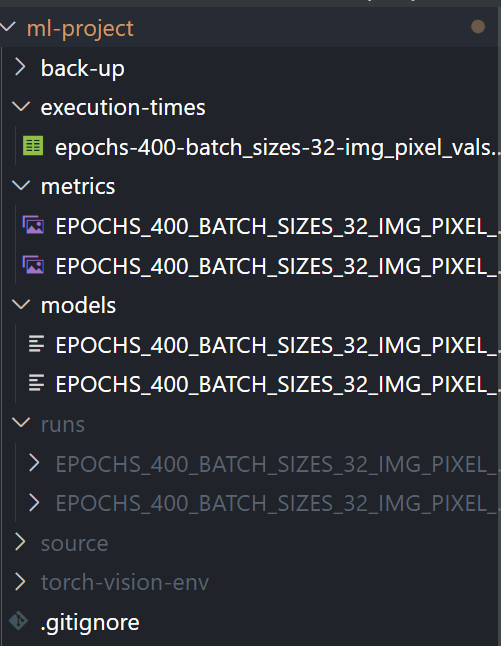

Additionally, an execution time logger was added to estimate, based on previous experiments, how long future experiments are likely to take.

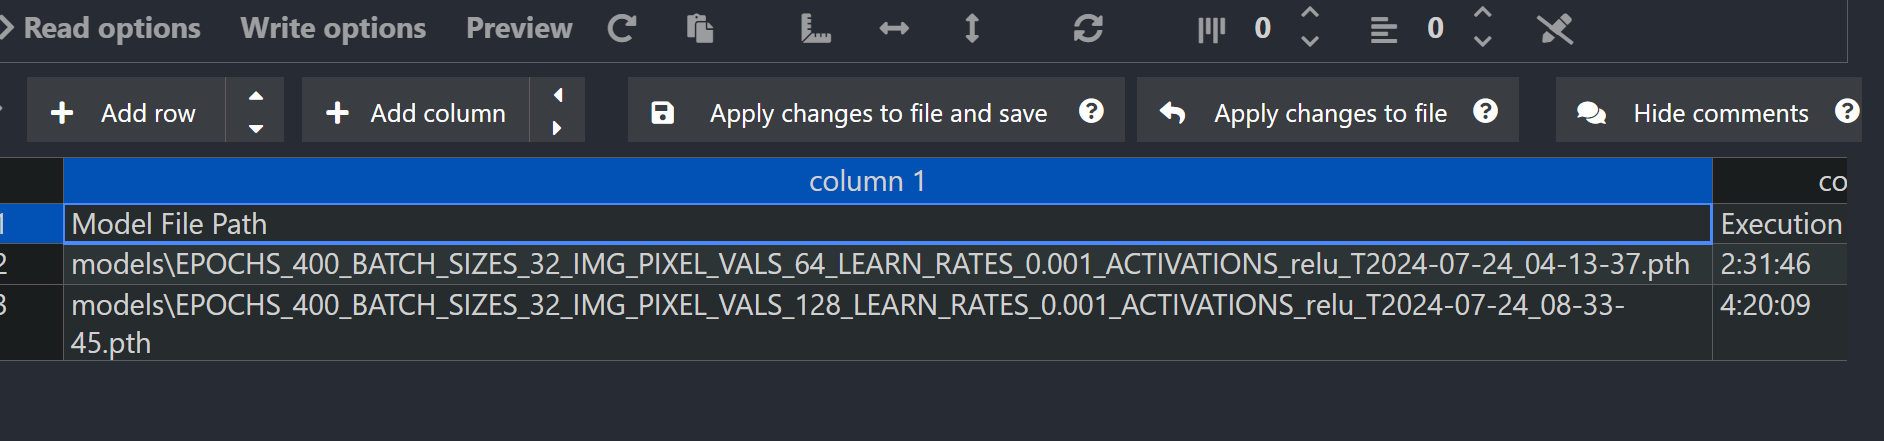

My goal was to bring the margin of error to less than 1%, which involved days of trial and error and tuning. This process was facilitated by the central config design that allowed everything to be controlled and logged dynamically until I was finally able to achieve this goal.

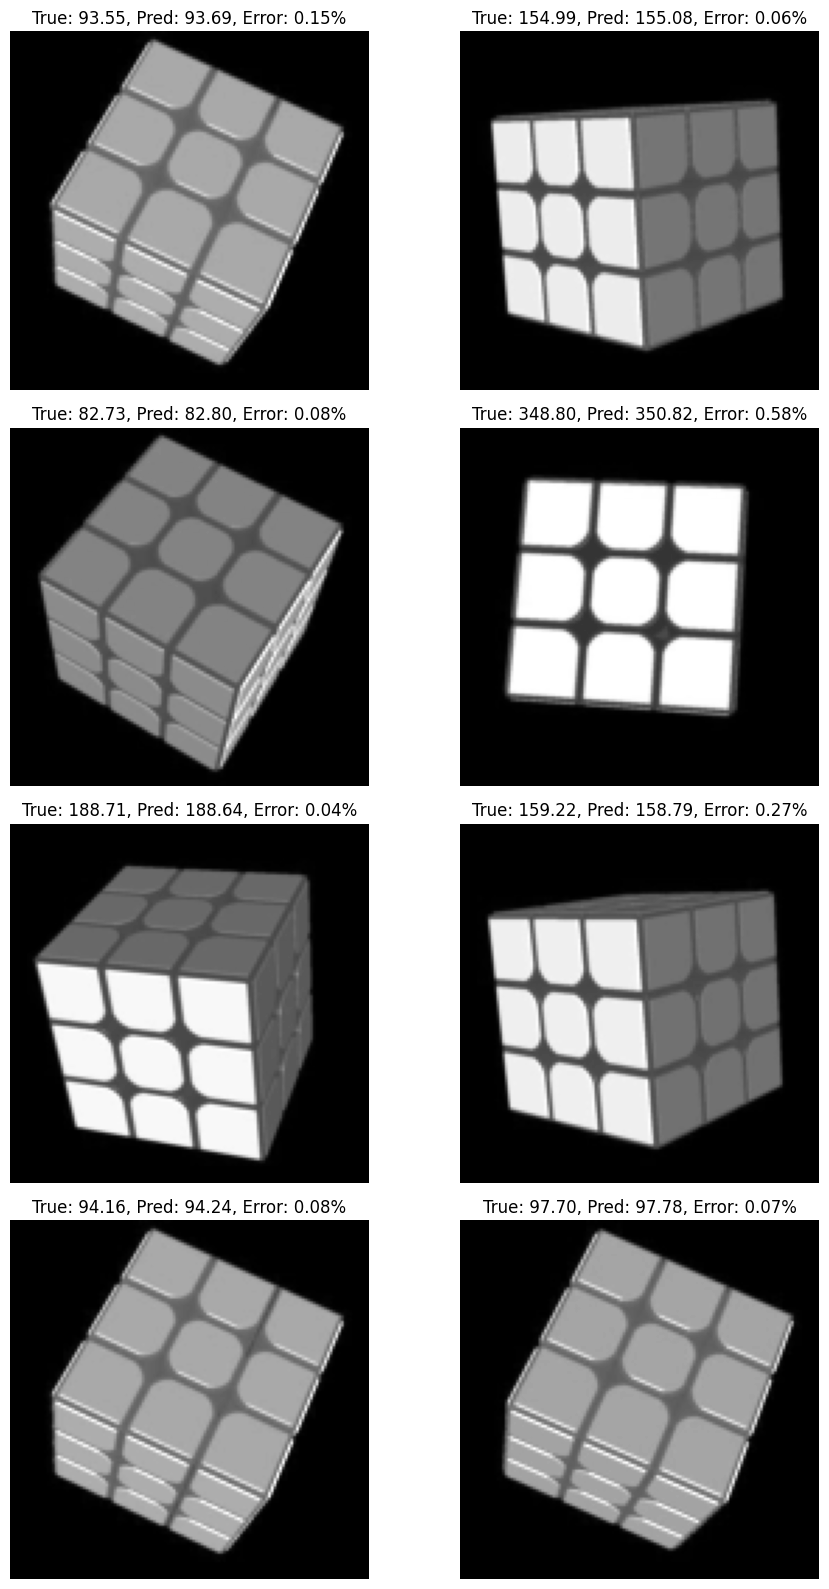

I tracked all metrics with a special focus on validation MSE, as that was the main metric for the evaluation of the coding challenge.

1. **Train/Loss and Validation/Loss**: Both loss graphs show a steep decline in the initial epochs, indicating that the model is learning rapidly. The training loss continues to decrease and stabilizes, while the validation loss shows more variability but also trends downwards. This suggests that the model is effectively learning from the training data and generalizing reasonably well to the validation data.

2. **Train/MAE and Validation/MAE**: The MAE graphs follow a similar pattern to the loss graphs, with the training MAE decreasing steadily and stabilizing. The validation MAE shows more fluctuations but indicates overall improvement. This reflects the model's decreasing average error in predicting the orientation of the Rubik's Cube.

3. **Train/MSE and Validation/MSE**: The MSE graphs also show a significant drop initially, with the training MSE stabilizing at a low value. The validation MSE, while more variable, indicates that the model is learning effectively and the errors are decreasing over time.

4. **Train/R2 and Validation/R2**: The R2 graphs show that the model's explanatory power increases rapidly in the initial epochs. The training R2 approaches 1, indicating that the model explains almost all the variance in the training data. The validation R2, although lower, demonstrates good generalization, with values consistently above 0.9 after the initial epochs.

these results indicate that the chosen activation functions, batch size, and learning rate are effectively contributing to the model's ability to learn and generalize from the training data. The graphs reflect successful training with minimal overfitting, as evidenced by the convergence and stabilization of both training and validation metrics.

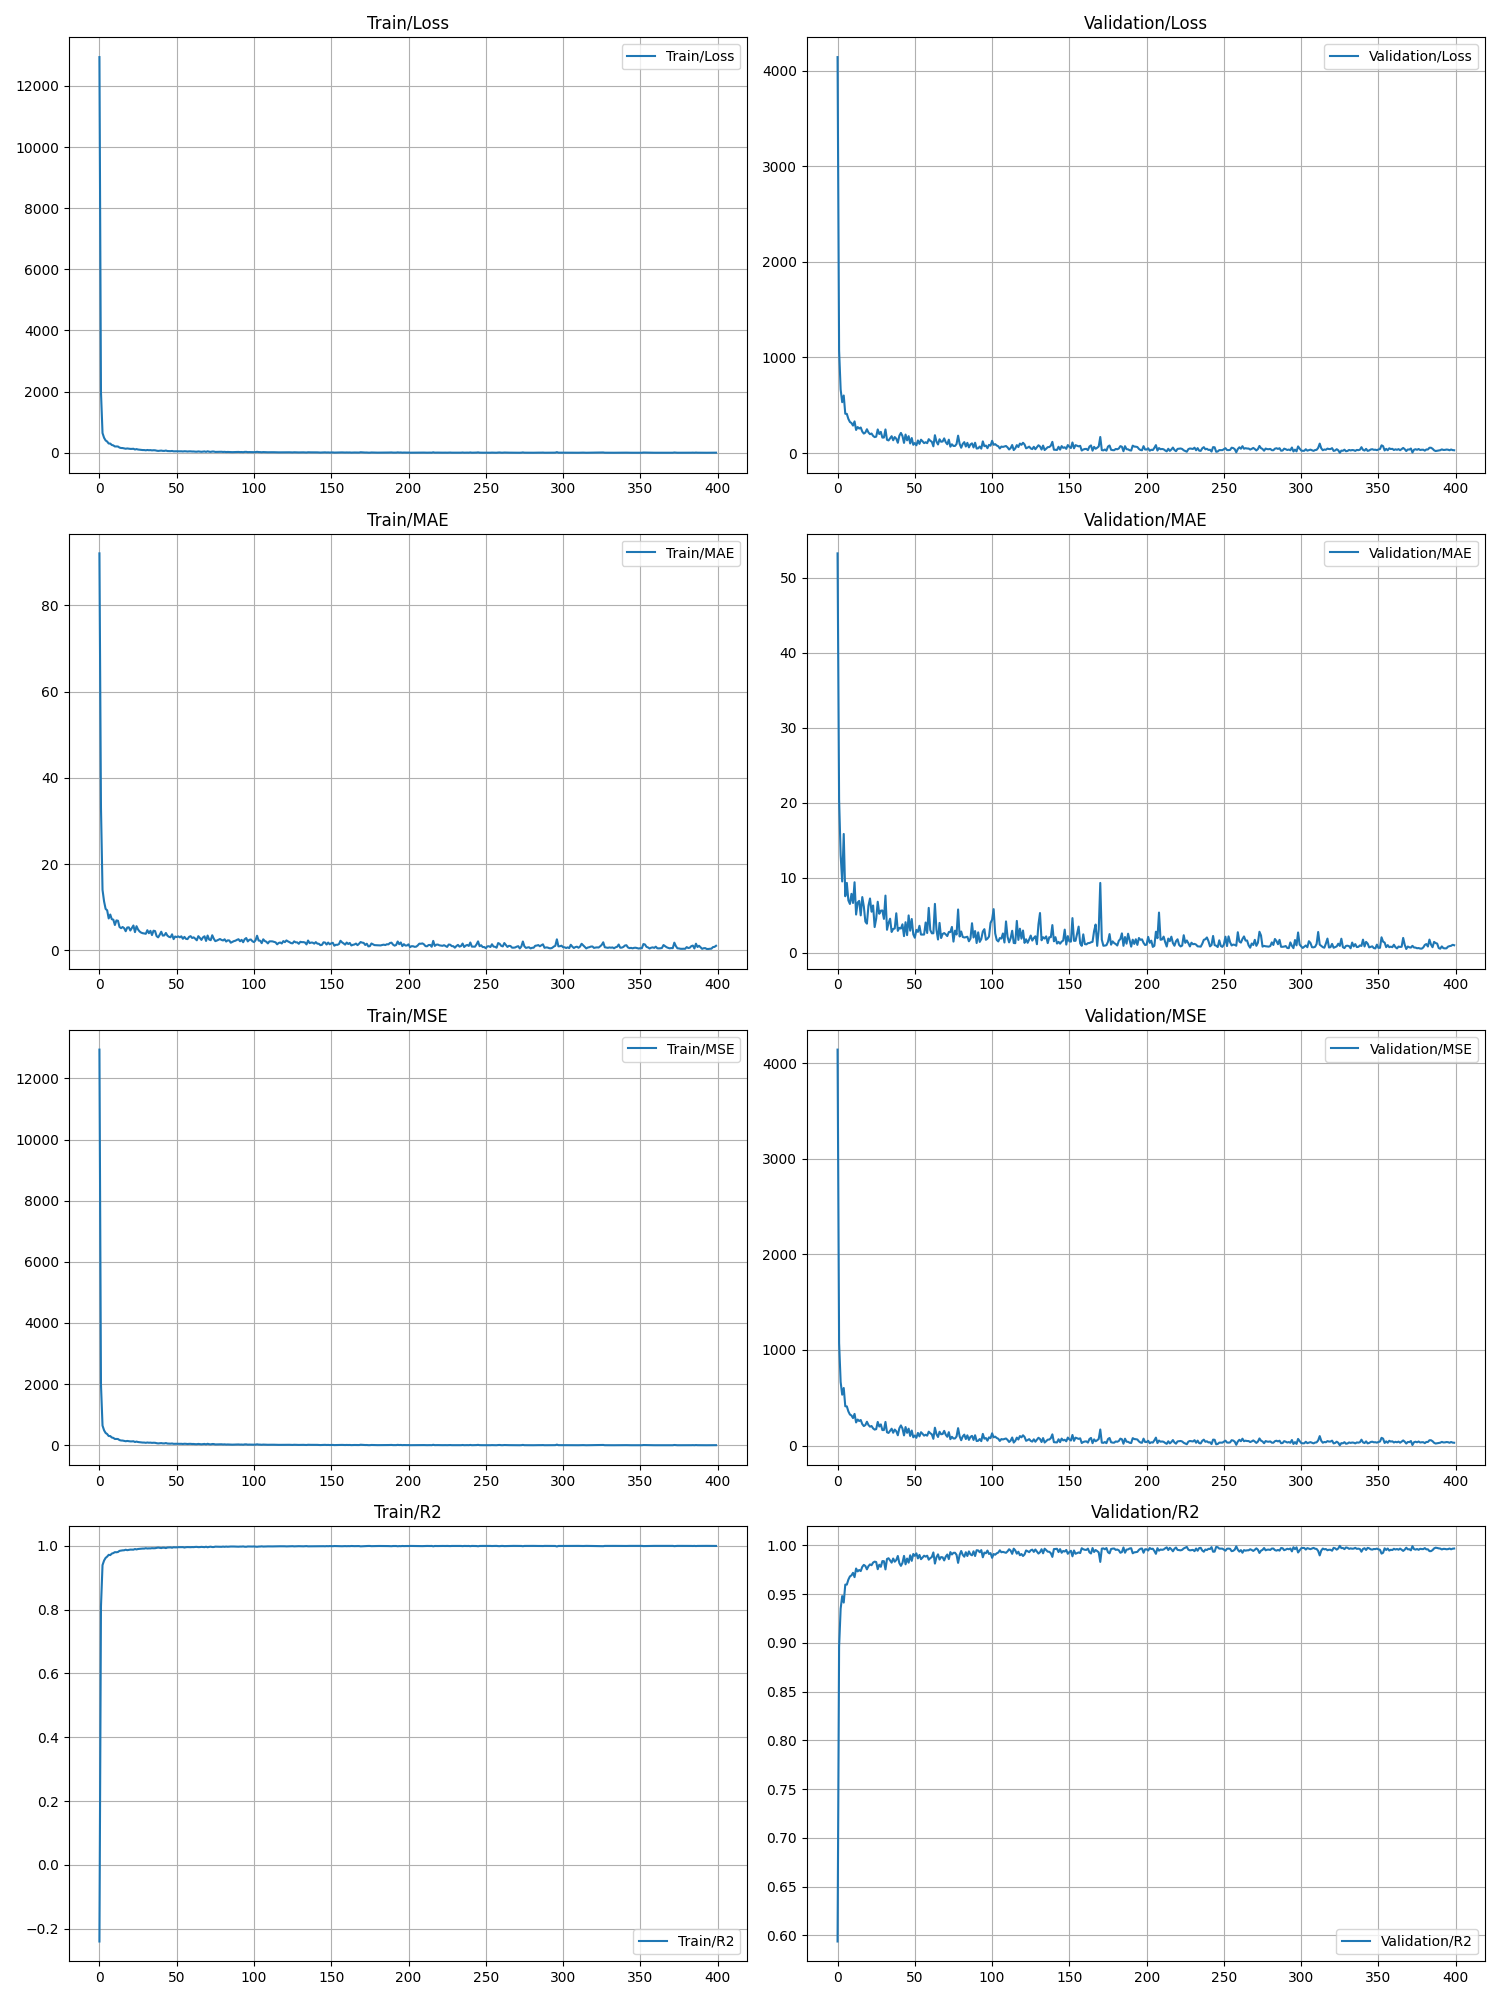

Here are screenshots from the final tensorboard :

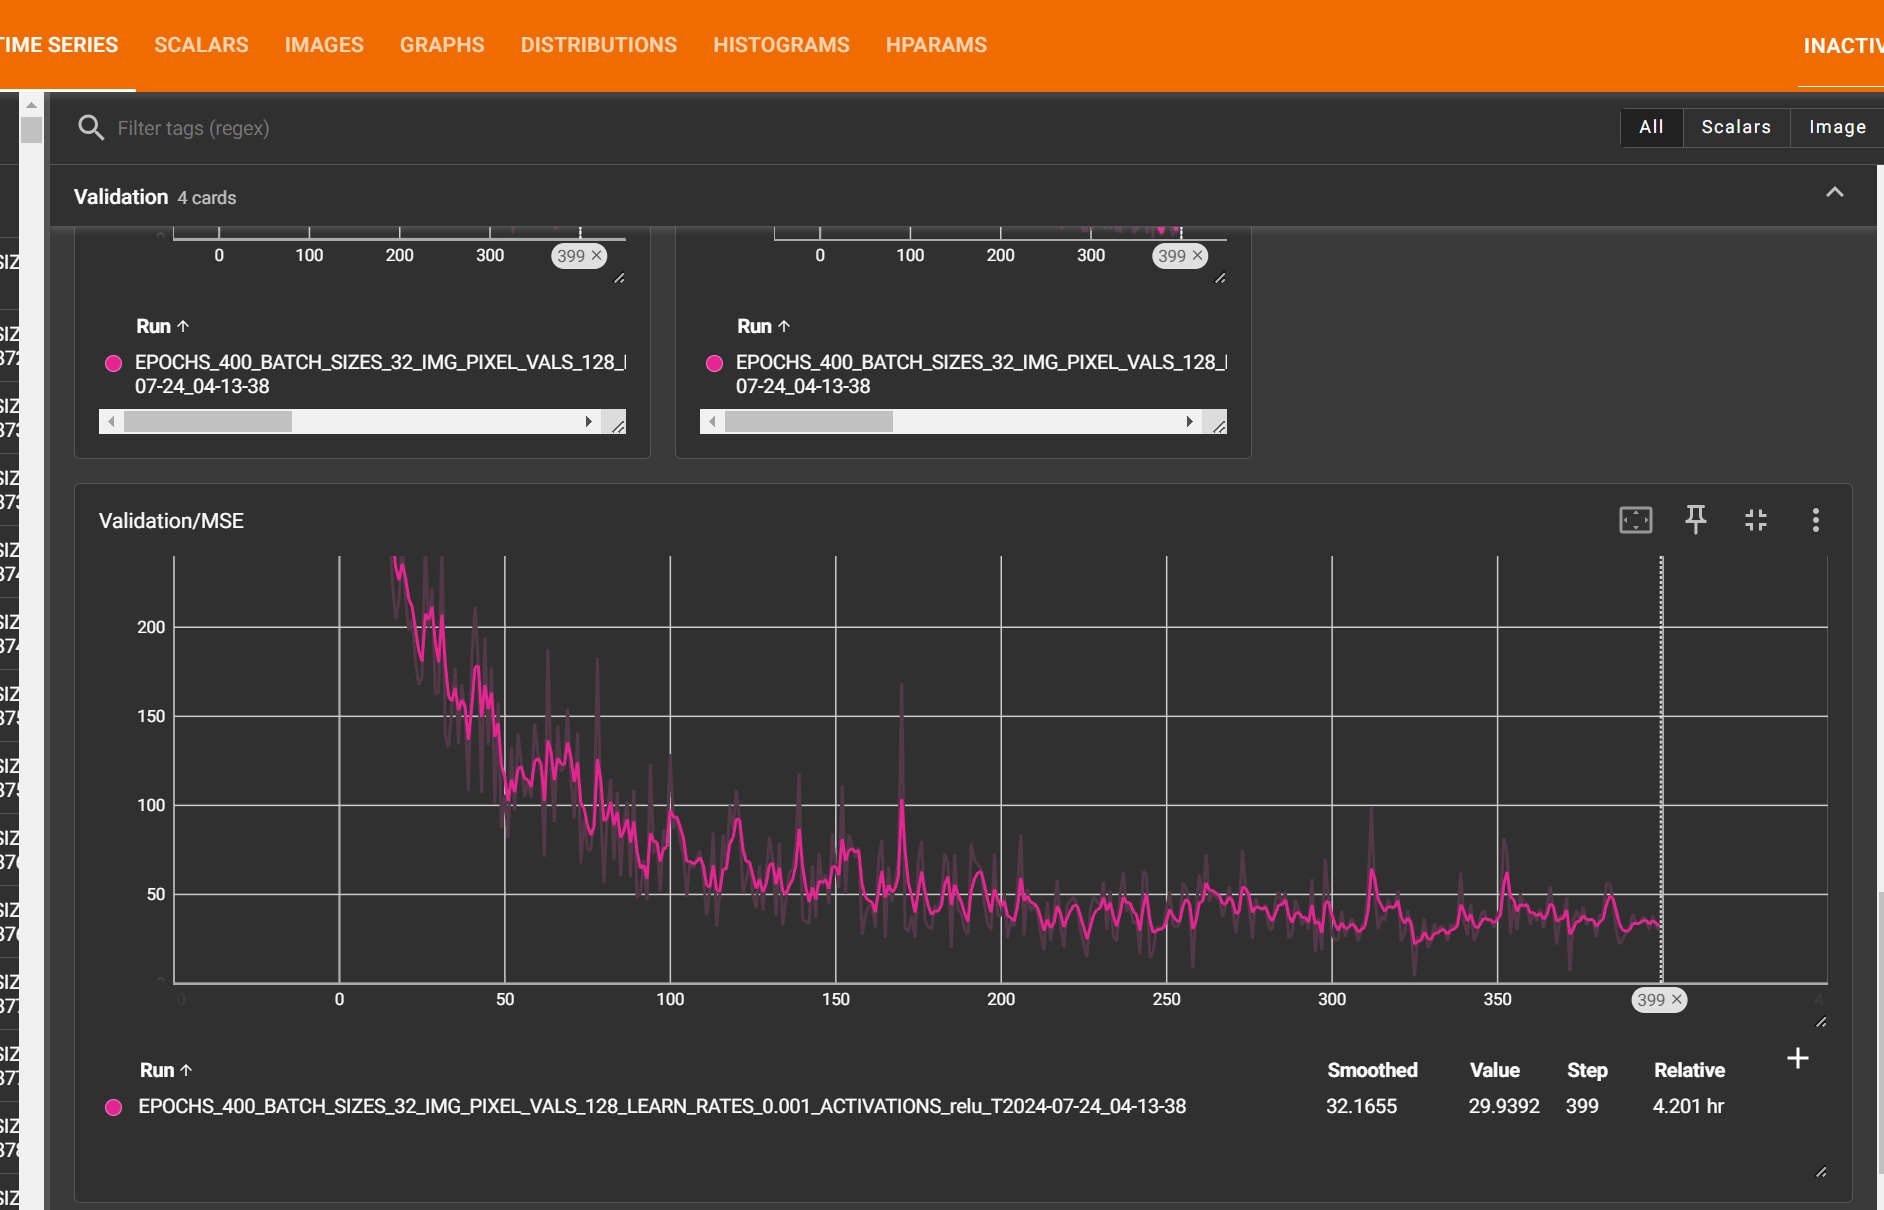

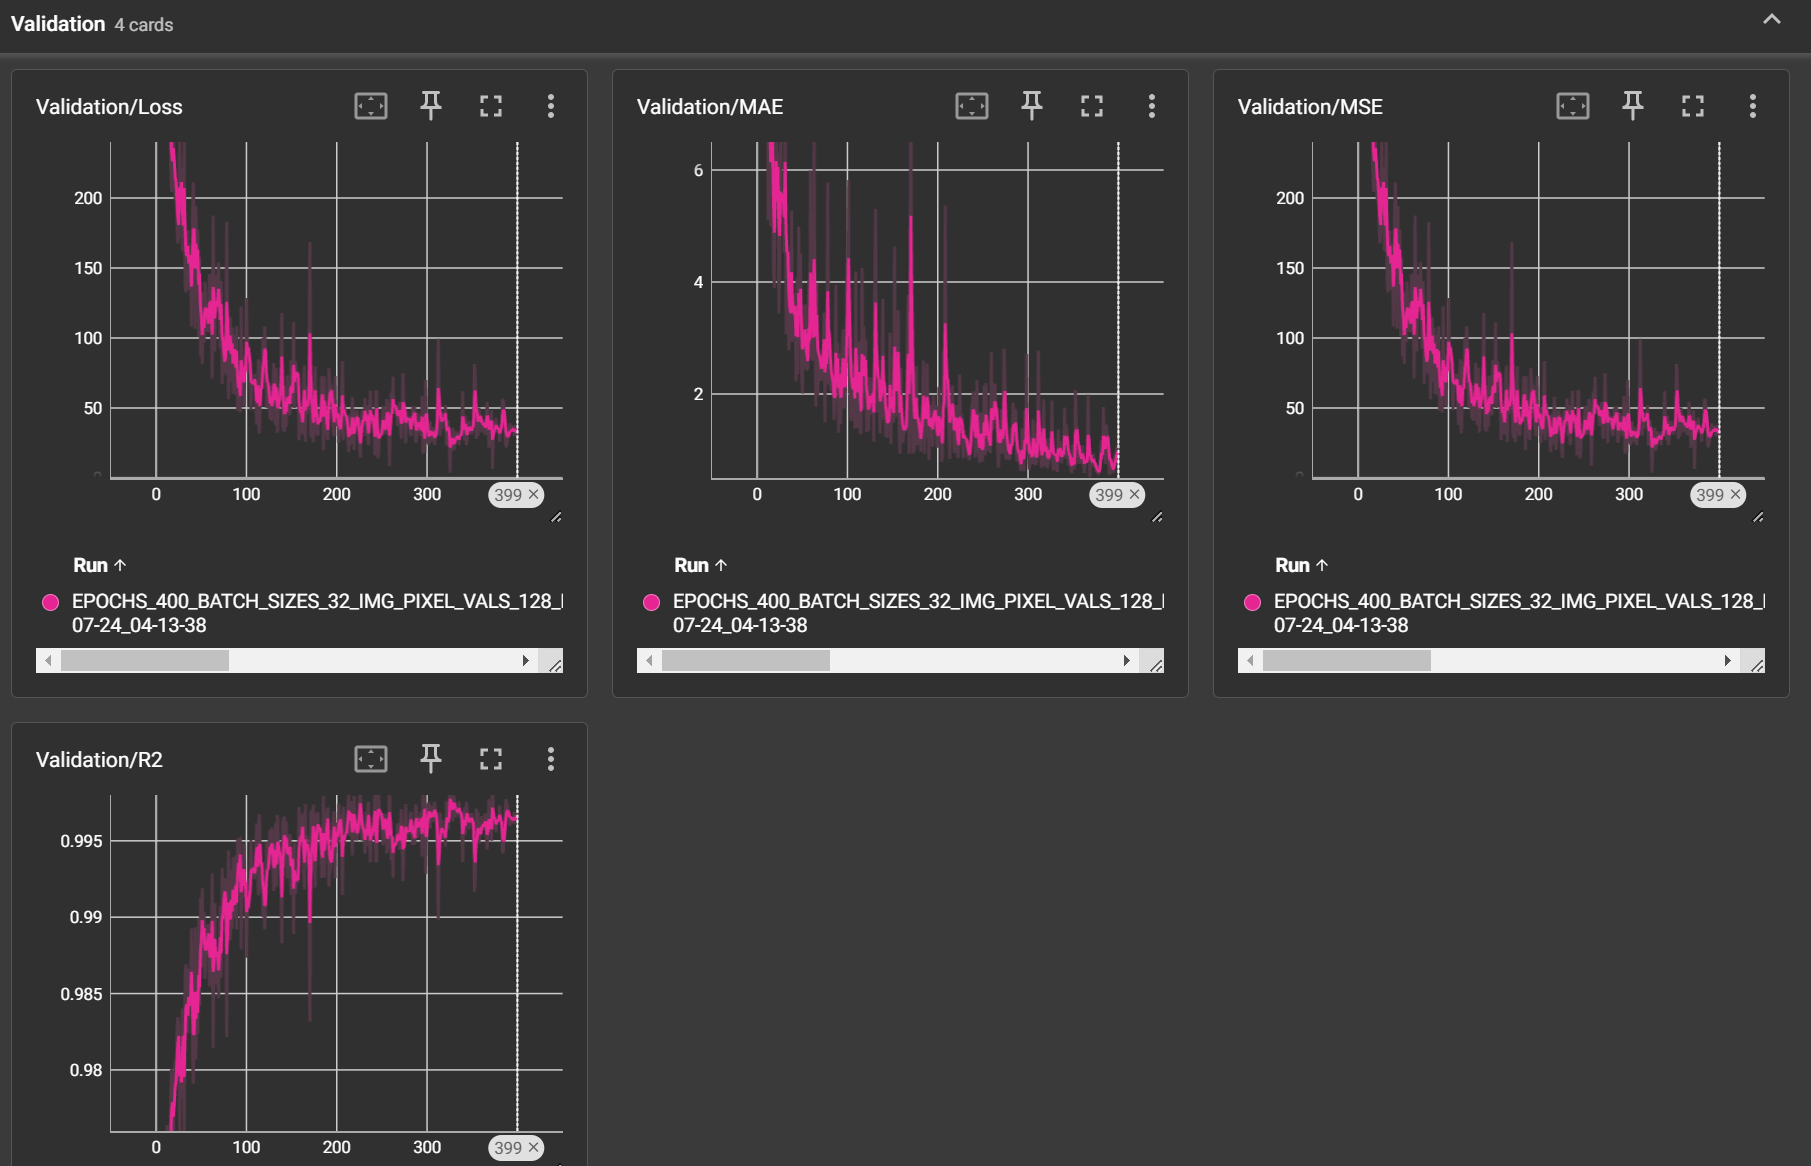

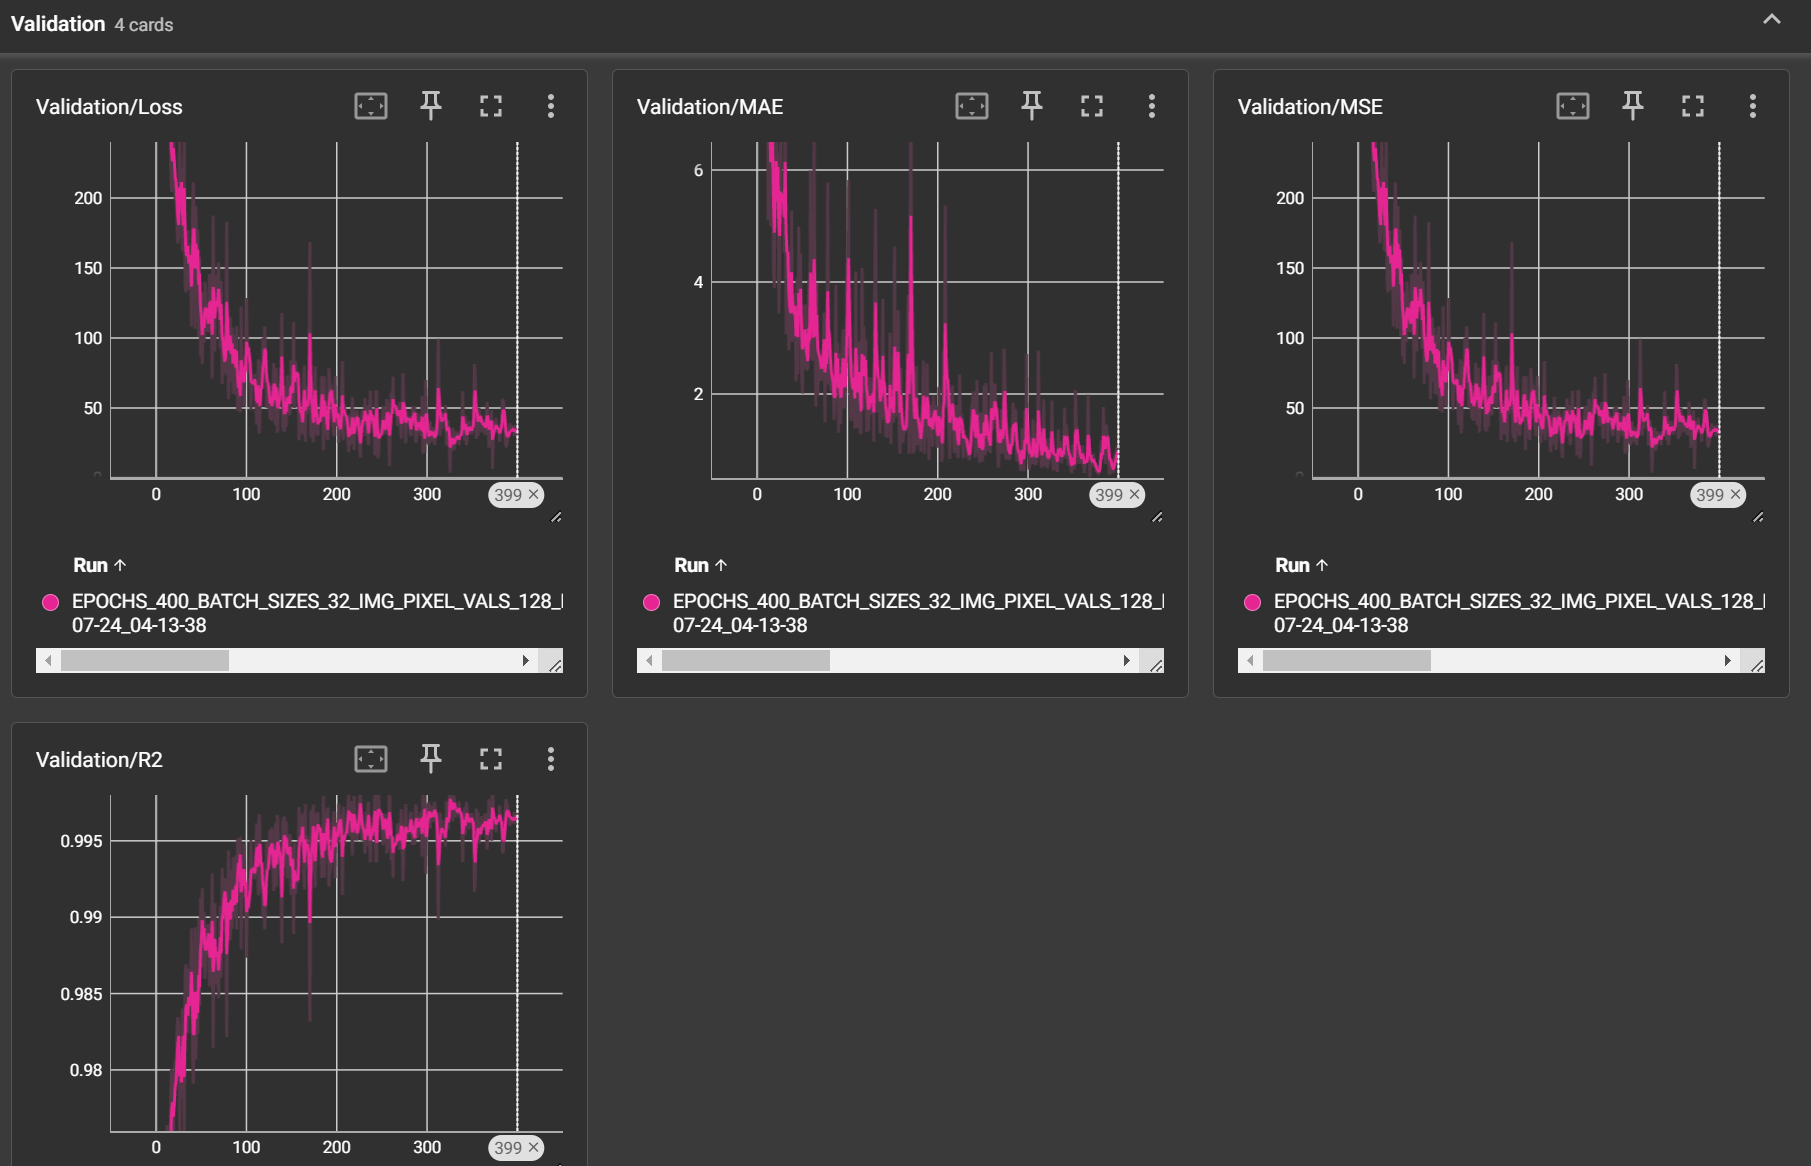

This graph displays the distribution of the parameter values in the first fully connected layer (fc1) after 400 epochs of training with a batch size of 32. The sharp peak at the center indicates a high concentration of parameter values around zero.

The convergence of parameters towards zero means that the model parameters have been adjusted through training to minimize the loss function effectively. This suggests a well-regularized model where weights are not excessively large, preventing overfitting and promoting better generalization to unseen data. The centralized distribution around zero also indicates that the model has learned to balance the weights efficiently, contributing to stable and effective learning.

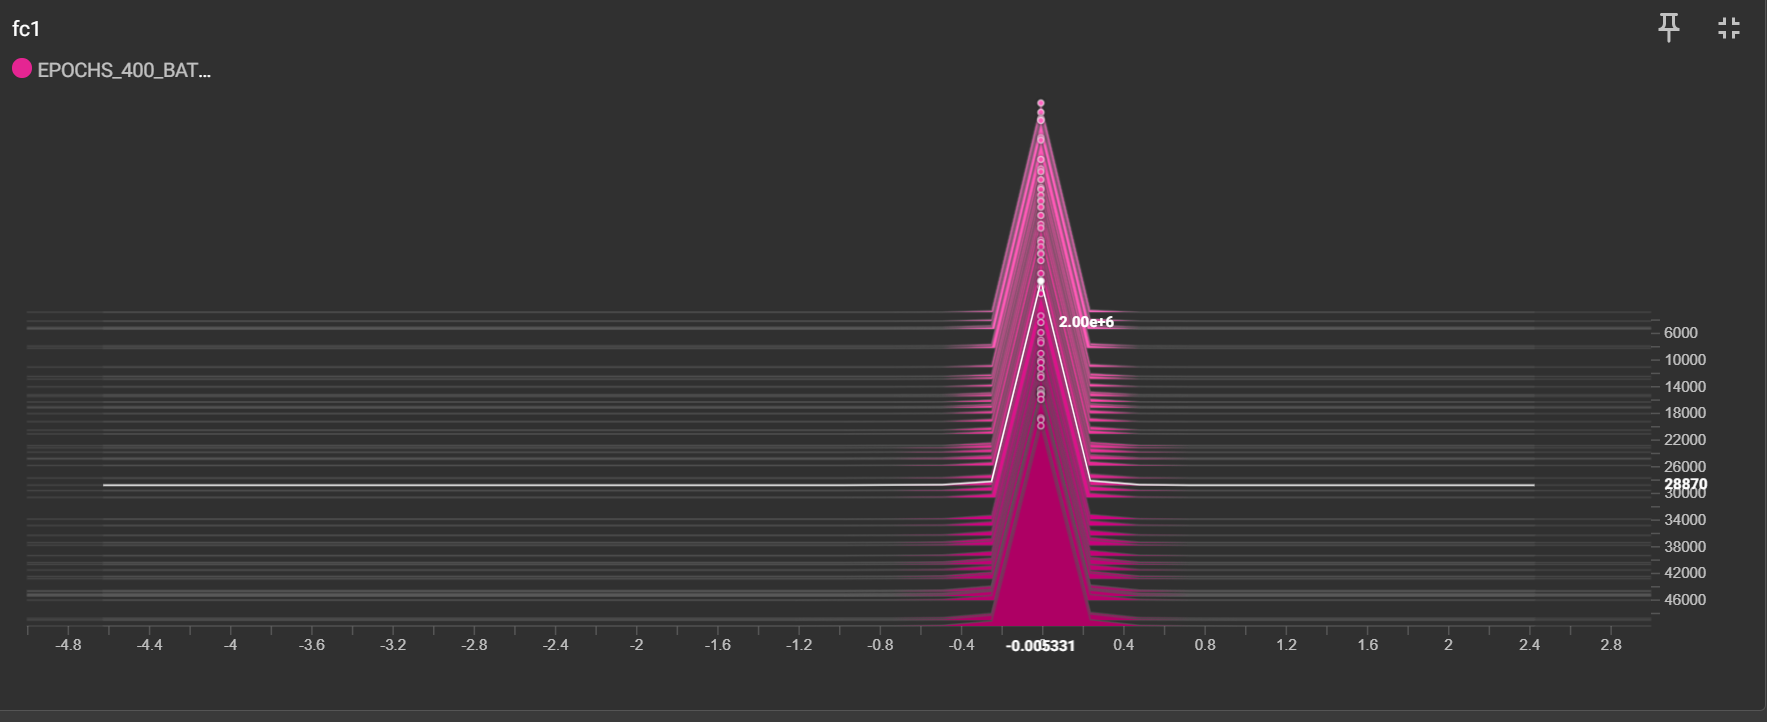
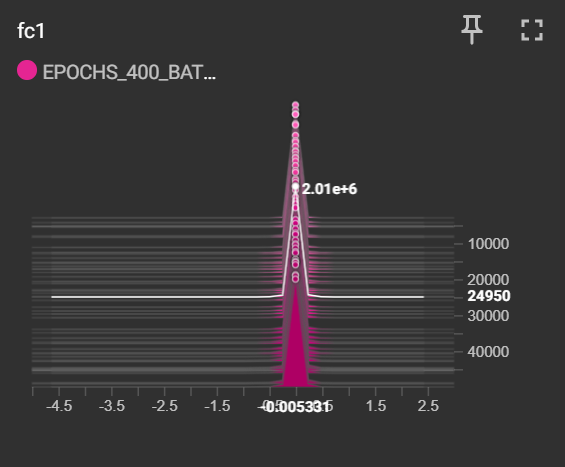

It is important to mention that it wasn't enough that the hyper-grid was dynamic and designed to seek an automatic tuning of all possible hyperparameters, as I thought at first. 

The process involved a lot of iterative trial and error, mixed with intuition on how to design the next experiment while still considering time and computational cost.

128 pixels were observed to perform best, and a batch size of 32 proved effective. However, this was only the case when the learning rate was reduced to 0.001. For activation functions, ReLU, leaky ReLU, and ELU performed best. ReLU and its variations were chosen because they are the modern default activation function for hidden layers is the ReLU function [8], so they were used for the comparison. It's worth noting that training could be stopped at around 30 epochs with satisfactory results. However, the training was extended to 400 epochs out of curiosity, which yielded slightly better results, but it's not necessary. The loss function MSELoss was also used (This loss function is suitable for regression problems like the Rubik's Cube orientation prediction, as it penalizes larger errors more heavily, leading to more accurate predictions) and the optimizer Adam. More loss functions and optimizers could still be tried in future versions; however, due to computation and time constraints, the decision was made to stop here, and the results were found to be satisfactory.


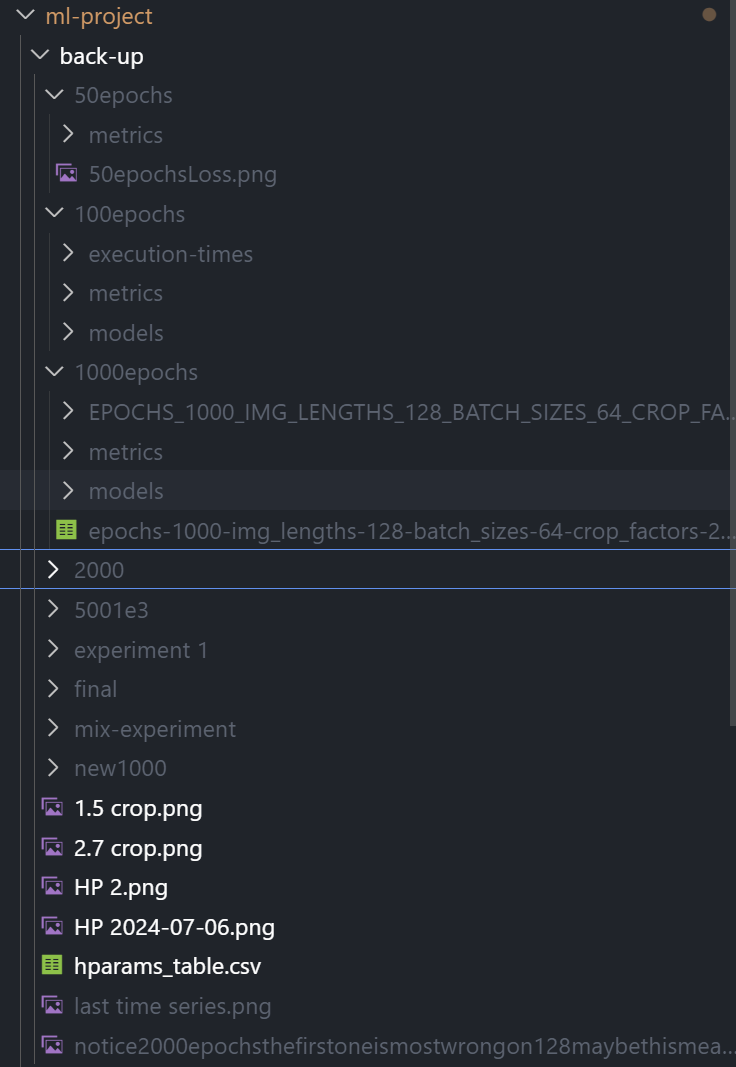
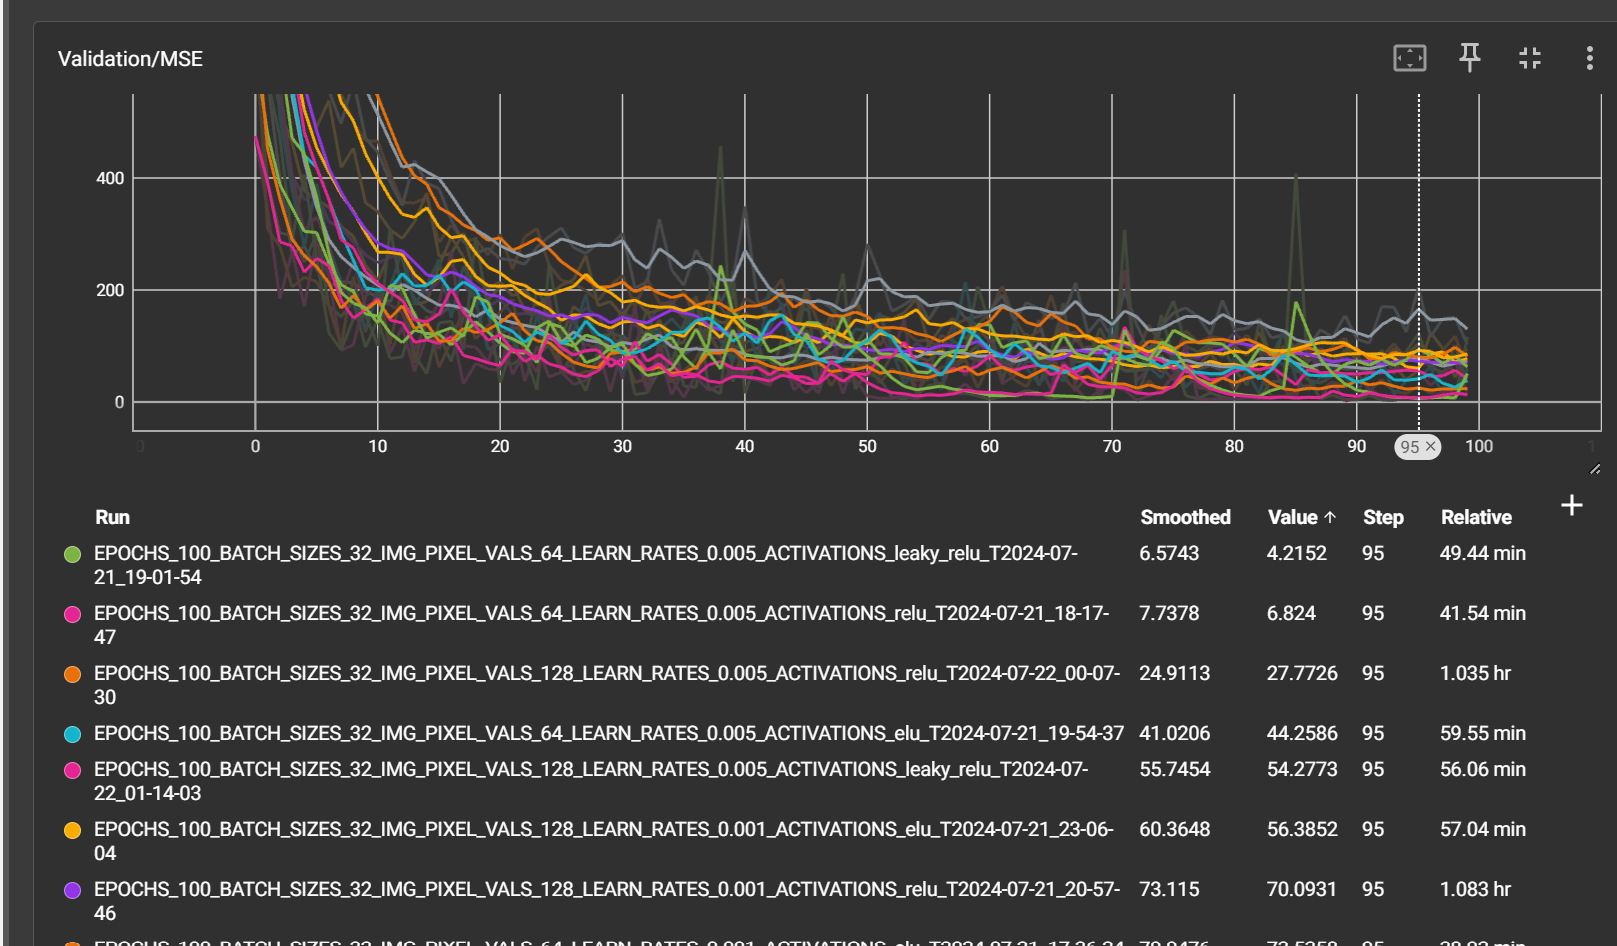

<a name="citation-and-declaration"></a>
# 11. Citation & Declaration


[1] KIIT AI Mini blitz challenge, Link: https://www.aicrowd.com/challenges/kiit-ai-mini-blitz.

[2] Dissertation Computer Vision-Assisted Surgery: Real-Time Instrument Tracking with Machine Learning Nicola Christin Rieke, Technische Universität München Fakultät für Informatik Lehrstuhl für Informatikanwendungen in der Medizin, Link: https://mediatum.ub.tum.de/doc/1435900/753802.pdf.

[3] Computing Mean & STD in Image Dataset, Link: https://kozodoi.me/blog/20210308/compute-image-stats.

[4] pytorch_image_regession Github Repo, Link: https://github.com/hugohadfield/pytorch_image_regession.

[5] CNN Architecture Boilerplate for image regression, Link: https://github.com/hugohadfield/pytorch_image_regession/blob/main/network.py.

[6] Tensorboard for PyTorch integration, Link: https://www.youtube.com/watch?v=RLqsxWaQdHE.

[7] Pytorch Documentation on Tensorbaord integration, Link: https://pytorch.org/docs/stable/tensorboard.html.

[8] How to Choose an Activation Function for Deep Learning, Link: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/